In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
import requests
import json
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/covid19countryinfo.csv
./input/states-daily.csv
./input/covid19-deepscore.csv
./input/population_data.csv
./input/full-list-total-tests-for-covid-19.csv
./input/country_codes.csv
./input/enriched_covid_19_week_2.csv
./input/covid19-global-forecasting-week-3/test.csv
./input/covid19-global-forecasting-week-3/submission.csv
./input/covid19-global-forecasting-week-3/train.csv
./input/korea/SeoulFloating.csv
./input/korea/TimeAge.csv
./input/korea/SearchTrend.csv
./input/korea/TimeProvince.csv
./input/korea/Weather.csv
./input/korea/PatientRoute.csv
./input/korea/PatientInfo.csv
./input/korea/Region.csv
./input/korea/TimeGender.csv
./input/korea/Case.csv
./input/korea/Time.csv
./input/covid19-global-forecasting-week-2/test.csv
./input/covid19-global-forecasting-week-2/submission.csv
./input/covid19-global-forecasting-week-2/train.csv
./input/covidAPI/ESP.json
./input/covidAPI/ICL.json
./input/covidAPI/CHN.json
./input/covidAPI/FRA.json
./input/covidAPI/THA.json
./input/covidAPI/DNK

# 2. Preparing the training data

In [2]:
def code_to_entity(code):
    dic = {"KOR": "South Korea", "ITA": "Italy", "FRA": "France", "DEU": "Germany", "ISL": "Iceland", "DNK": "Denmark", "THA": "Thailand", "TWN": "Taiwan"}
    return dic[code]

In [3]:
# Get API data (confirmed, deaths, recovered)
# filter by country codes
country_codes = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]

for country in country_codes:
    response = requests.get('https://covidapi.info/api/v1/country/{}'.format(country))
    try:
        data = response.json()
    except:
        print("{} not found".format(country))
    with open("./input/covidAPI/{}.json".format(country), "w") as f:
        json.dump(data["result"], f, indent=4)

In [4]:
original_df = pd.read_csv("./input/full-list-total-tests-for-covid-19.csv")

# unify date format
original_df["Date"] = [datetime.strftime(datetime.strptime(date, '%b %d, %Y'), '%Y-%m-%d') for date in original_df["Date"]]
original_df = original_df.rename(columns={"Total tests": "test"})
original_df.head()

Entity Code        Date   test
0  Argentina  ARG  2020-04-08  13330
1  Argentina  ARG  2020-04-09  14850
2  Argentina  ARG  2020-04-10  16379
3  Argentina  ARG  2020-04-11  18027
4  Argentina  ARG  2020-04-13  19758

In [5]:
original_df = original_df.query("Code in {}".format(country_codes))
original_df.reset_index(inplace=True, drop=True)
original_df.head()

Entity Code        Date   test
0  Denmark  DNK  2020-03-17   7630
1  Denmark  DNK  2020-03-19   8847
2  Denmark  DNK  2020-03-20  11657
3  Denmark  DNK  2020-03-21  12351
4  Denmark  DNK  2020-03-22  12843

In [6]:
# Merge Dataframe
import json

new_df = original_df
for code in country_codes:
    with open("./input/covidAPI/{}.json".format(code), "r") as f:
        j = json.load(f)
    # for each date
    for key in j.keys():
        # for each in (confirmed, deaths, recovered)
        for k in j[key].keys():
            if ((new_df['Code'] == code) & (new_df['Date'] == key)).any():
                new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == key), k] = j[key][k]
            else:
                s = pd.Series([code_to_entity(code), code, key, j[key][k]], index=["Entity", "Code", "Date", k])
                new_df = new_df.append(s,ignore_index=True)
new_df = new_df.sort_values(['Code', 'Date'])
new_df.reset_index(inplace=True, drop=True)
print(new_df.head())

    Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   NaN        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   NaN        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   NaN        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   NaN        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   NaN        0.0     0.0        0.0


In [7]:
# Interpolate
new_df["test"].where(new_df["confirmed"] != 0.0, 0.0, inplace=True)
# add test values to unique countries
for code in ["THA", "TWN"]:
    first_confirmed = new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "confirmed"].values[0]
    new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "test"] = new_df.loc[(new_df["Code"] == "KOR") & (new_df["confirmed"] == first_confirmed), "test"].values[0]

for code in country_codes:
    tmp_df = new_df[new_df["Code"] == code]
    tmp_df.interpolate(inplace=True)
    new_df[new_df["Code"]==code] = tmp_df
print(new_df.head())

/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


    Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   0.0        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   0.0        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   0.0        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   0.0        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   0.0        0.0     0.0        0.0


In [8]:
# Add rates
# new_df["infectious_rate"] = (new_df["test"] - new_df["negative"]) / new_df["test"]
new_df["infectious_rate"] = new_df["confirmed"] / new_df["test"]
new_df["removed_rate"] = (new_df["deaths"] + new_df["recovered"]) / new_df["test"]
new_df["susceptible_rate"] = 1.0 - (new_df["infectious_rate"] + new_df["removed_rate"])
new_df["infectious_rate_change"] = 0.0
new_df["removed_rate_change"] = 0.0
new_df["susceptible_rate_change"] = 0.0

# Drop nulls
new_df.dropna(how='any', inplace=True)
print(new_df.head())

    Entity Code        Date          test  confirmed  deaths  recovered  \
5  Germany  DEU  2020-01-27   2969.428571        1.0     0.0        0.0   
6  Germany  DEU  2020-01-28   5938.857143        4.0     0.0        0.0   
7  Germany  DEU  2020-01-29   8908.285714        4.0     0.0        0.0   
8  Germany  DEU  2020-01-30  11877.714286        4.0     0.0        0.0   
9  Germany  DEU  2020-01-31  14847.142857        5.0     0.0        0.0   

   infectious_rate  removed_rate  susceptible_rate  infectious_rate_change  \
5         0.000337           0.0          0.999663                     0.0   
6         0.000674           0.0          0.999326                     0.0   
7         0.000449           0.0          0.999551                     0.0   
8         0.000337           0.0          0.999663                     0.0   
9         0.000337           0.0          0.999663                     0.0   

   removed_rate_change  susceptible_rate_change  
5                  0.0        

In [9]:
# Smoothing
def mu_sigma_justify(Y, floor_n=1, ceil_n=1.5, mu=None, sigma=None):
    """μとσを用いた補正関数。
    Args:
        floor_n (float):
        ceil_n (float):
        mu (Optional[float]):
        sigma (Optional[float]):
    """
    mu = mu or Y.mean()
    sigma = sigma or Y.std()
    Y = Y.copy()
    Y_ = Y.copy()
    Y[abs(Y_ - mu) < floor_n * sigma] = mu  # μ±σ ⇒ μ
    Y[Y_ > mu + ceil_n * sigma] = mu + ceil_n * sigma  # μ＋3σ より大きい ⇒ μ＋3σ
    Y[Y_ < mu - ceil_n * sigma] = mu - ceil_n * sigma  # μー3σ より小さい ⇒ μー3σ
    return Y

In [10]:
def compare_smoothing(df):
    plt.plot(tmp_df["infectious_rate"].values)
    plt.plot(mu_sigma_justify(tmp_df["infectious_rate"].values))
    plt.title("Infectious Rate Smoothing Comparison")
    plt.ylabel('Infectious Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(df["Date"].values)),df["Date"].values,rotation='vertical')
    plt.legend(['Before', 'After'], loc='best')
    plt.show()
    
    plt.plot(tmp_df["removed_rate"].values)
    plt.plot(mu_sigma_justify(tmp_df["removed_rate"].values))
    plt.title("Removed Rate Smoothing Comparison")
    plt.ylabel('Removed Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(df["Date"].values)),df["Date"].values,rotation='vertical')
    plt.legend(['Before', 'After'], loc='best')
    plt.show()

def display_rate(tmp_df):
    plt.plot(tmp_df["infectious_rate"].values)
    plt.plot(tmp_df["removed_rate"].values)
    plt.plot(tmp_df["susceptible_rate"].values)
    plt.title("Rate")
    plt.ylabel('Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(tmp_df.Date.values)),tmp_df.Date.values,rotation='vertical')
    plt.legend(['Infectious Rate', 'Removed Rate', 'Susceptible Rate'], loc='best')
    plt.show()

In [11]:
# Calculate Change Rate
for code in country_codes:
    print("-----------------{}------------------".format(code))

    # normalize
    # compare_smoothing(tmp_df)
    # tmp_df["infectious_rate"] = mu_sigma_justify(tmp_df["infectious_rate"].values)
    # tmp_df["removed_rate"] = mu_sigma_justify(tmp_df["removed_rate"].values)
    # tmp_df["susceptible_rate"] = mu_sigma_justify(tmp_df["susceptible_rate"].values)

    tmp_df = new_df[new_df["Code"] == code]
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate"].pct_change()
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["removed_rate_change"] = tmp_df["removed_rate"].pct_change()
    tmp_df["removed_rate_change"] = tmp_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].pct_change()
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    new_df[new_df["Code"]==code] = tmp_df
    
# Save
new_df.to_csv("./input/covid19-deepscore.csv")

-----------------KOR------------------


/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

-----------------ITA------------------
-----------------FRA------------------
-----------------DEU------------------
-----------------ISL------------------
-----------------DNK------------------
-----------------THA------------------
-----------------TWN------------------


In [37]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def gamma(x):
    return x * x * 1/50000

In [38]:
# Creating SIR inputs
from scipy.integrate import odeint
import random

# A grid of time points (in days)
days = 160

# Initial SIR dataframe
cols = ['Code', 'Date', 'confirmed', 'removed', 'susceptible', 'infectious_rate', 'removed_rate', 'susceptible_rate', 'infectious_rate_change', 'removed_rate_change', 'susceptible_rate_change']
SIR_df = pd.DataFrame(index=[], columns=cols)

dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start='2020-02-01', periods=days, freq='D')]
print(dates)

['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020

--------------------------------------------------------
first beta=2.8230564209255686e-06, first gamma=0.0
last beta=8.989430379655513e-08, last gamma=0.50562


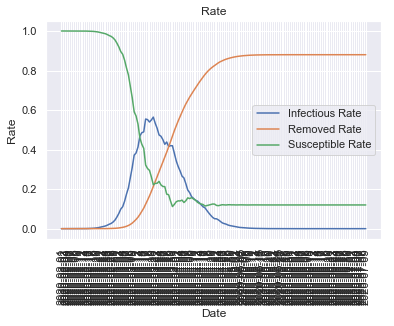

--------------------------------------------------------
first beta=2.956644632608113e-06, first gamma=0.0
last beta=1.3935211890261694e-07, last gamma=0.50562


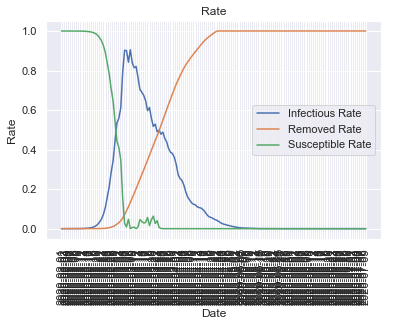

--------------------------------------------------------
first beta=3.2698921919983685e-06, first gamma=0.0
last beta=1.0636636809546278e-07, last gamma=0.50562


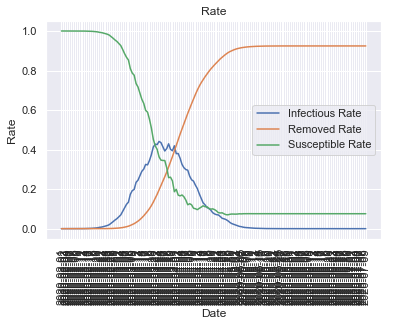

--------------------------------------------------------
first beta=3.2697854037810018e-06, first gamma=0.0
last beta=1.6205921376826588e-07, last gamma=0.50562


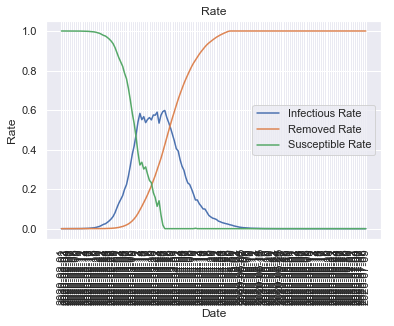

--------------------------------------------------------
first beta=2.571445618424655e-06, first gamma=0.0
last beta=6.578136721025258e-08, last gamma=0.50562


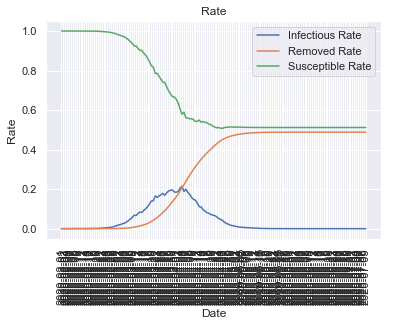

--------------------------------------------------------
first beta=2.3604446511170622e-06, first gamma=0.0
last beta=6.607594156407313e-08, last gamma=0.50562


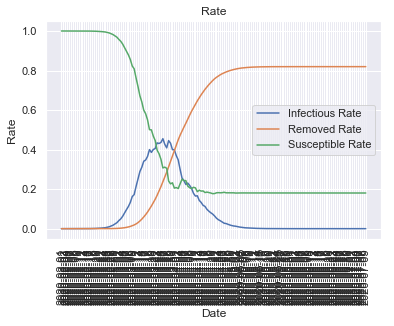

--------------------------------------------------------
first beta=2.7717280876815257e-06, first gamma=0.0
last beta=1.331926278864876e-07, last gamma=0.50562


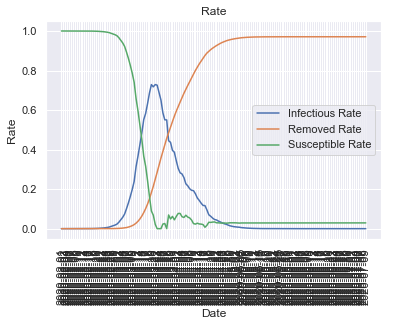

--------------------------------------------------------
first beta=3.128105385190322e-06, first gamma=0.0
last beta=1.0538830830473337e-07, last gamma=0.50562


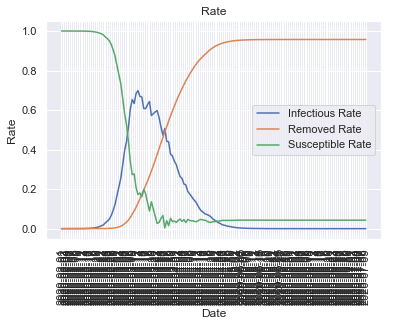

--------------------------------------------------------
first beta=2.9303328191150934e-06, first gamma=0.0
last beta=7.939887639341268e-08, last gamma=0.50562


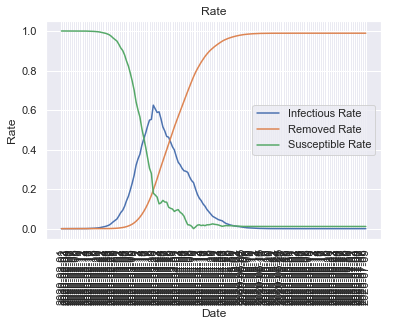

--------------------------------------------------------
first beta=2.999441058580928e-06, first gamma=0.0
last beta=1.525902571229991e-07, last gamma=0.50562


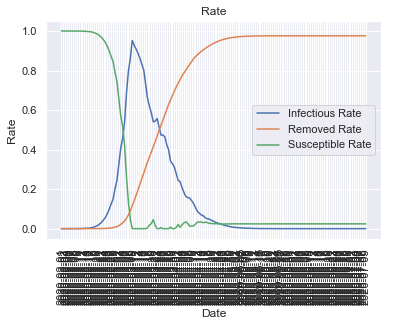

--------------------------------------------------------
first beta=2.471836392358287e-06, first gamma=0.0
last beta=8.803786501490799e-08, last gamma=0.50562


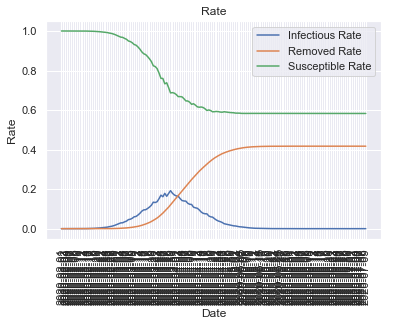

--------------------------------------------------------
first beta=3.463078688483216e-06, first gamma=0.0
last beta=1.279544395606712e-07, last gamma=0.50562


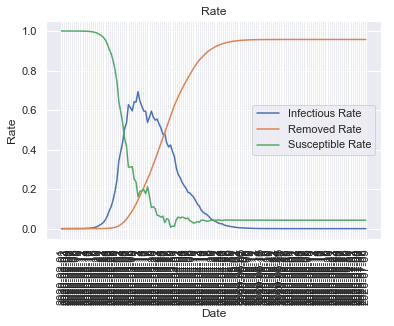

--------------------------------------------------------
first beta=2.856409912145557e-06, first gamma=0.0
last beta=3.382006753170684e-07, last gamma=0.50562


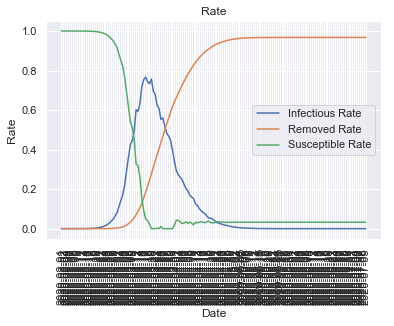

--------------------------------------------------------
first beta=2.9363754061482815e-06, first gamma=0.0
last beta=7.883297888801977e-08, last gamma=0.50562


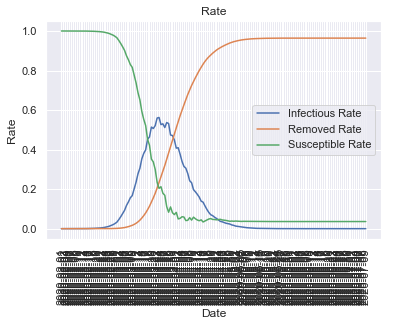

--------------------------------------------------------
first beta=3.1486218067043984e-06, first gamma=0.0
last beta=1.72132401147313e-07, last gamma=0.50562


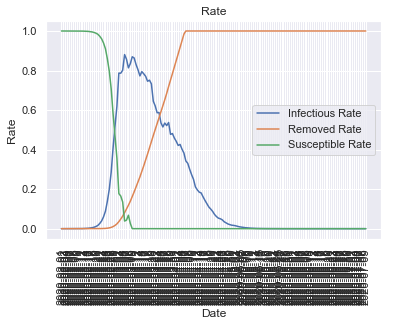

--------------------------------------------------------
first beta=3.2893523844393215e-06, first gamma=0.0
last beta=1.2622898399421292e-07, last gamma=0.50562


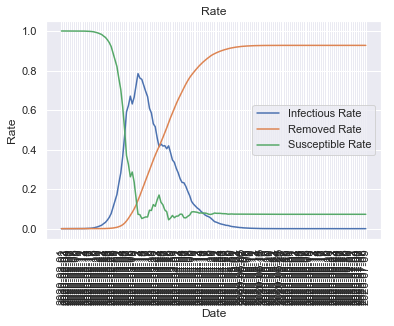

--------------------------------------------------------
first beta=2.6566179564191196e-06, first gamma=0.0
last beta=1.5083728338967662e-07, last gamma=0.50562


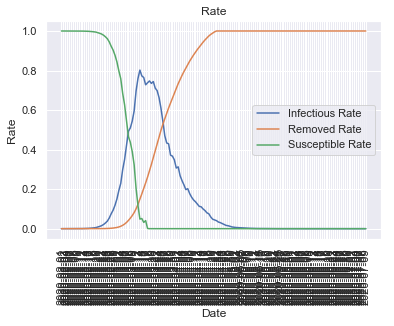

--------------------------------------------------------
first beta=2.7401951075544967e-06, first gamma=0.0
last beta=4.116757039470939e-08, last gamma=0.50562


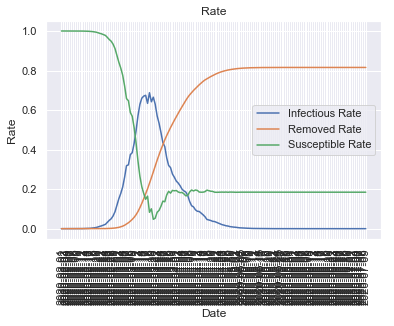

--------------------------------------------------------
first beta=2.8825664031136934e-06, first gamma=0.0
last beta=1.0456402370173465e-07, last gamma=0.50562


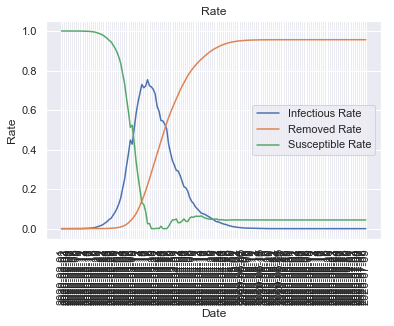

--------------------------------------------------------
first beta=2.4619514225791555e-06, first gamma=0.0
last beta=3.8375464300921486e-07, last gamma=0.50562


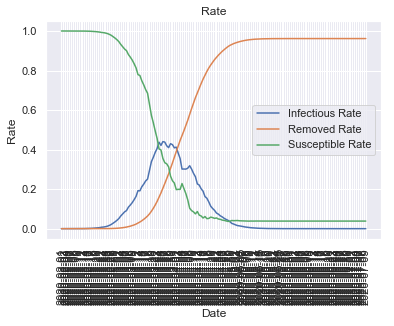

--------------------------------------------------------
first beta=3.0785511424269394e-06, first gamma=0.0
last beta=2.578267486832086e-07, last gamma=0.50562


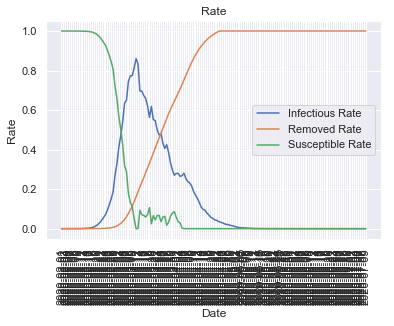

--------------------------------------------------------
first beta=3.107043212900469e-06, first gamma=0.0
last beta=2.17010008262483e-07, last gamma=0.50562


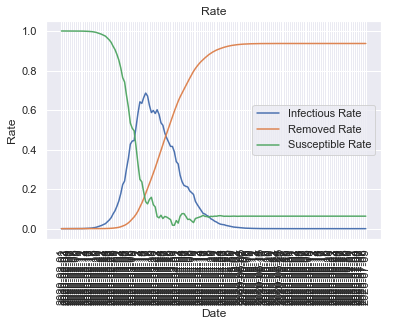

--------------------------------------------------------
first beta=2.9989435119690736e-06, first gamma=0.0
last beta=1.3840346392854704e-07, last gamma=0.50562


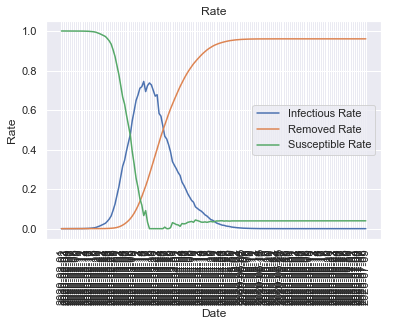

--------------------------------------------------------
first beta=2.858059600999601e-06, first gamma=0.0
last beta=4.37664144387502e-08, last gamma=0.50562


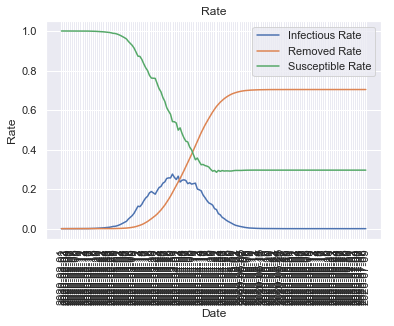

--------------------------------------------------------
first beta=3.1186071728339965e-06, first gamma=0.0
last beta=8.42402792670381e-08, last gamma=0.50562


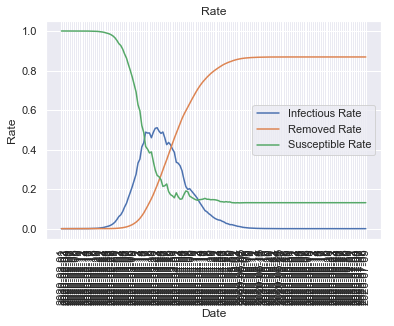

--------------------------------------------------------
first beta=3.4704058623138877e-06, first gamma=0.0
last beta=9.234856697871736e-08, last gamma=0.50562


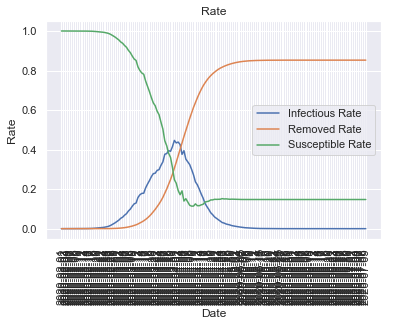

--------------------------------------------------------
first beta=2.8097867116713316e-06, first gamma=0.0
last beta=1.8656277826355358e-07, last gamma=0.50562


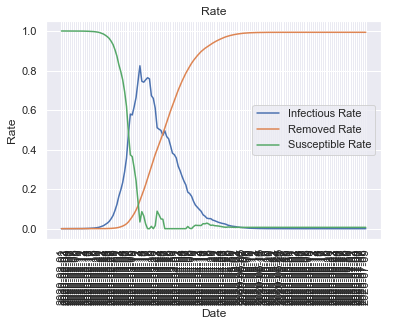

--------------------------------------------------------
first beta=2.9522296973125877e-06, first gamma=0.0
last beta=1.9632048706254964e-07, last gamma=0.50562


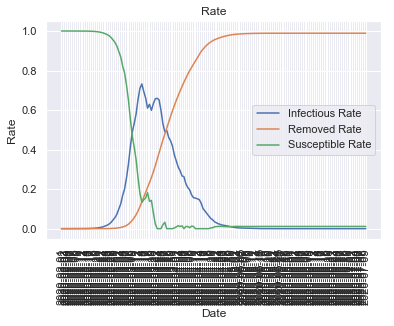

--------------------------------------------------------
first beta=2.3998128443785038e-06, first gamma=0.0
last beta=6.178772061928403e-08, last gamma=0.50562


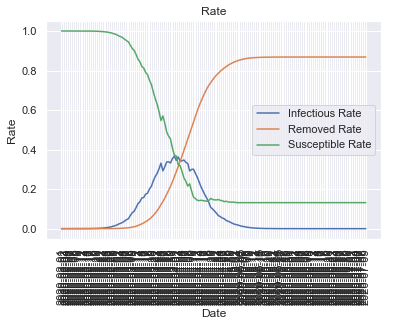

--------------------------------------------------------
first beta=3.4029088450037895e-06, first gamma=0.0
last beta=2.1218946472445893e-07, last gamma=0.50562


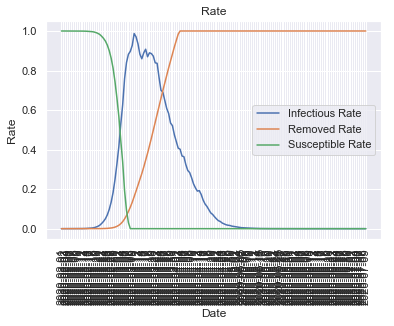

--------------------------------------------------------
first beta=2.786405353861968e-06, first gamma=0.0
last beta=2.894023629110164e-07, last gamma=0.50562


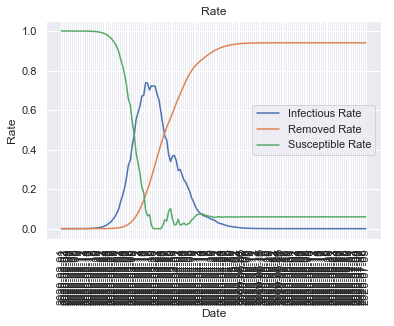

--------------------------------------------------------
first beta=2.864944118696182e-06, first gamma=0.0
last beta=1.1295118654818841e-07, last gamma=0.50562


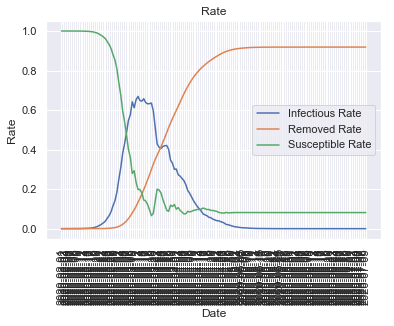

--------------------------------------------------------
first beta=2.3894707701253967e-06, first gamma=0.0
last beta=8.993737479084466e-08, last gamma=0.50562


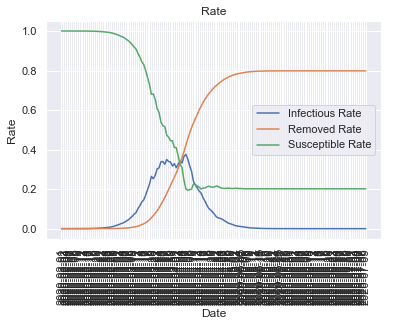

--------------------------------------------------------
first beta=2.5094022214815556e-06, first gamma=0.0
last beta=1.0059180449889221e-07, last gamma=0.50562


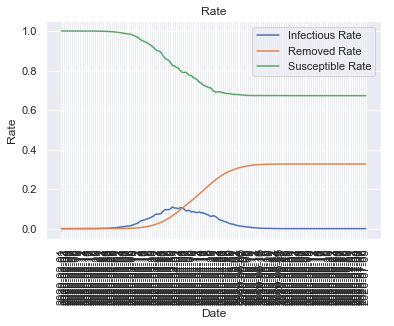

--------------------------------------------------------
first beta=3.1418971455079225e-06, first gamma=0.0
last beta=8.025753618476324e-08, last gamma=0.50562


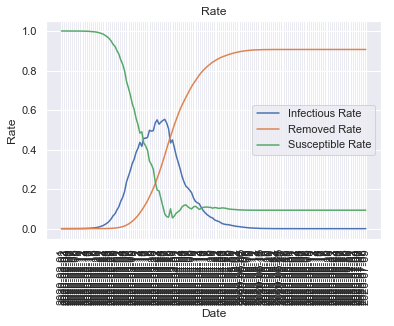

--------------------------------------------------------
first beta=2.911244078802059e-06, first gamma=0.0
last beta=1.7837228422365482e-07, last gamma=0.50562


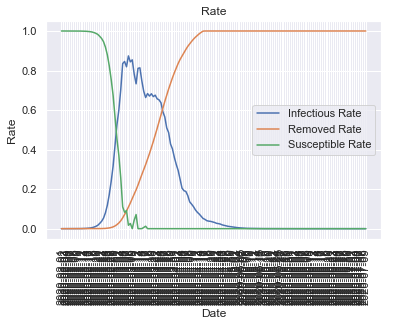

--------------------------------------------------------
first beta=3.1464684125113873e-06, first gamma=0.0
last beta=1.4594727403399428e-07, last gamma=0.50562


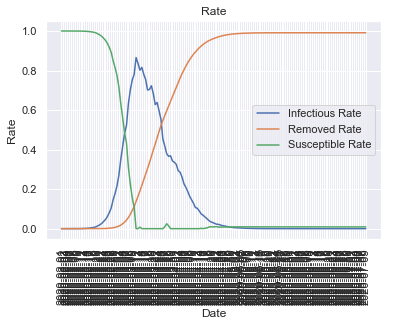

--------------------------------------------------------
first beta=2.9667405049514707e-06, first gamma=0.0
last beta=2.2939952221319628e-07, last gamma=0.50562


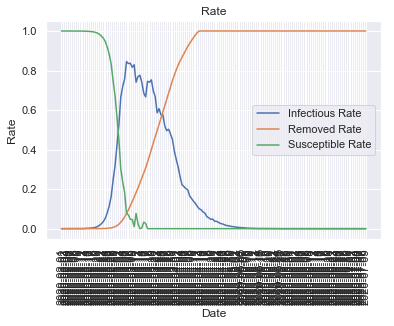

--------------------------------------------------------
first beta=3.2889479829887506e-06, first gamma=0.0
last beta=2.0422615619976203e-07, last gamma=0.50562


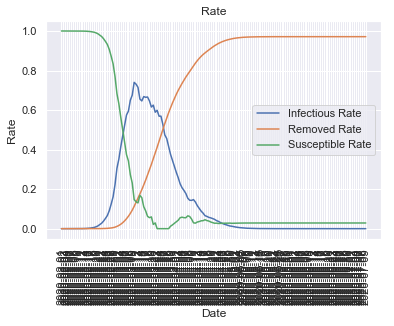

--------------------------------------------------------
first beta=2.621834478893373e-06, first gamma=0.0
last beta=6.781075328149004e-08, last gamma=0.50562


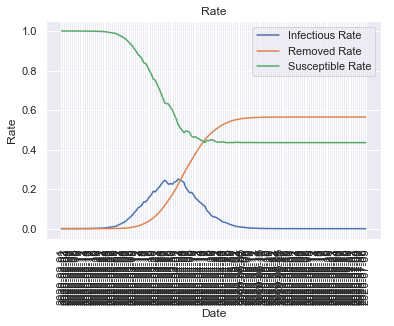

--------------------------------------------------------
first beta=2.644945761860307e-06, first gamma=0.0
last beta=1.4973350206798408e-07, last gamma=0.50562


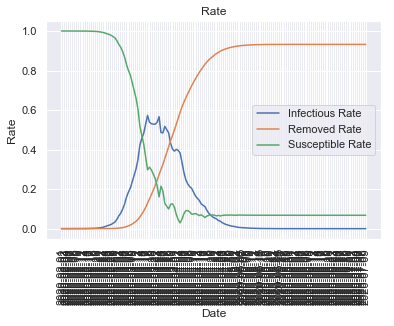

--------------------------------------------------------
first beta=2.6463628567696913e-06, first gamma=0.0
last beta=4.754227572589316e-07, last gamma=0.50562


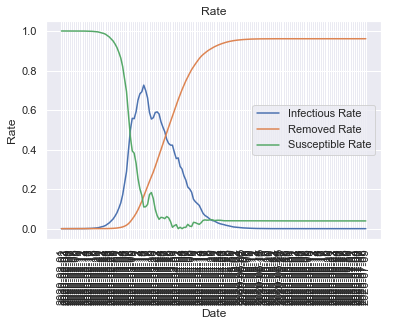

--------------------------------------------------------
first beta=3.120573054569273e-06, first gamma=0.0
last beta=8.858351114160136e-08, last gamma=0.50562


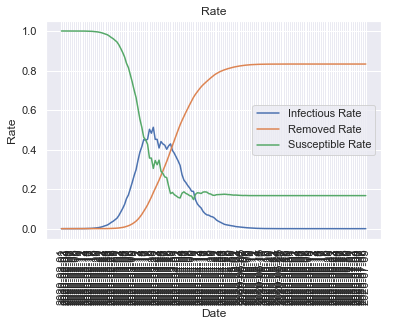

--------------------------------------------------------
first beta=2.4402469934086075e-06, first gamma=0.0
last beta=1.2385288165137592e-07, last gamma=0.50562


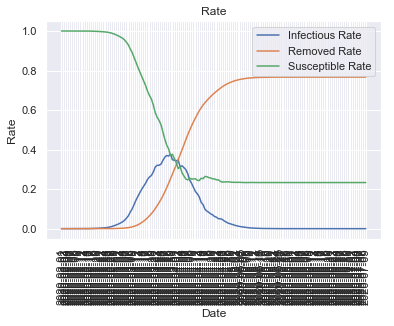

--------------------------------------------------------
first beta=3.49284480698905e-06, first gamma=0.0
last beta=1.2456712639979184e-07, last gamma=0.50562


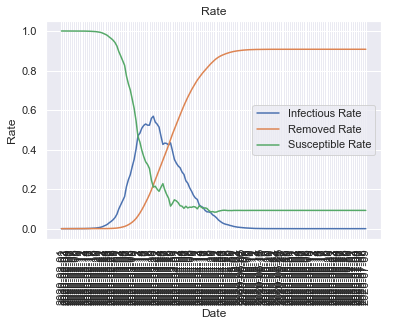

--------------------------------------------------------
first beta=2.765254174089676e-06, first gamma=0.0
last beta=9.193781733886649e-08, last gamma=0.50562


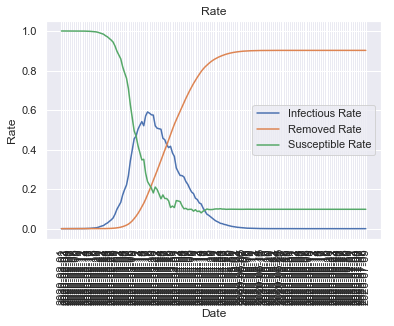

--------------------------------------------------------
first beta=3.065957413920375e-06, first gamma=0.0
last beta=6.765329563789539e-08, last gamma=0.50562


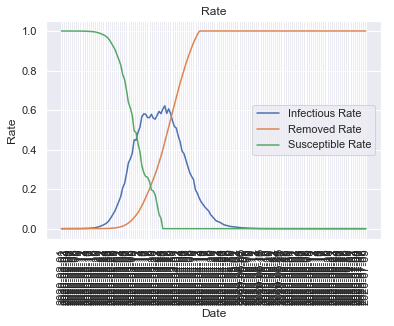

--------------------------------------------------------
first beta=3.4593711501918665e-06, first gamma=0.0
last beta=6.523029564530769e-08, last gamma=0.50562


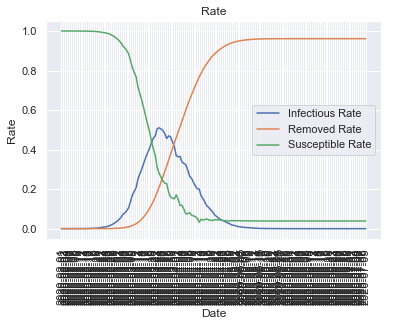

--------------------------------------------------------
first beta=3.1502296246834593e-06, first gamma=0.0
last beta=2.898046588447446e-07, last gamma=0.50562


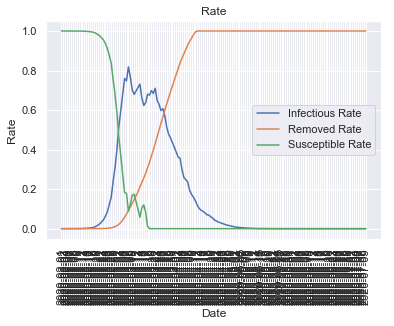

--------------------------------------------------------
first beta=2.44692745211041e-06, first gamma=0.0
last beta=1.5445682727066866e-07, last gamma=0.50562


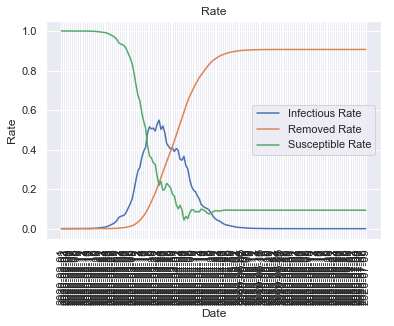

--------------------------------------------------------
first beta=2.69718655531776e-06, first gamma=0.0
last beta=8.101551506958822e-08, last gamma=0.50562


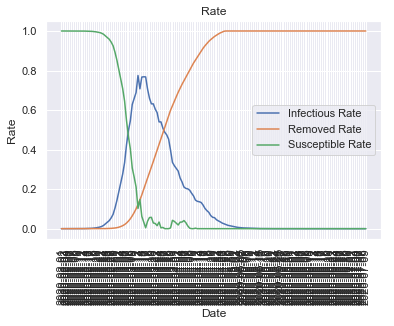

--------------------------------------------------------
first beta=3.0933394233777386e-06, first gamma=0.0
last beta=2.1063752286969018e-07, last gamma=0.50562


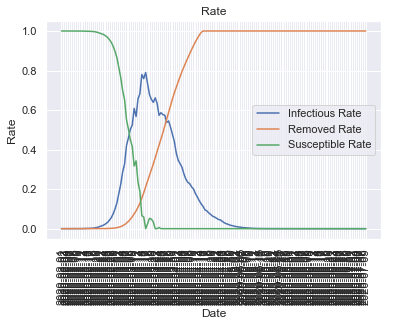

--------------------------------------------------------
first beta=3.1726407508285284e-06, first gamma=0.0
last beta=1.7566823156993536e-07, last gamma=0.50562


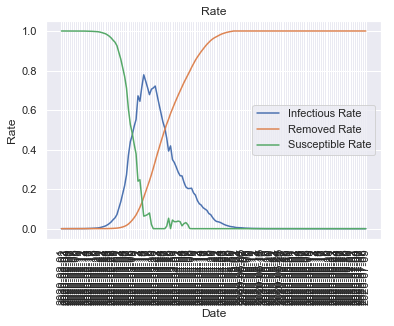

--------------------------------------------------------
first beta=2.371143340389964e-06, first gamma=0.0
last beta=1.2516164396085066e-07, last gamma=0.50562


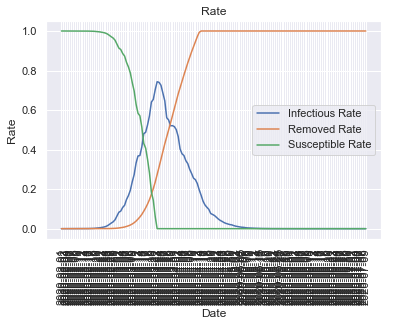

--------------------------------------------------------
first beta=2.3812541542721846e-06, first gamma=0.0
last beta=4.2861859153173145e-07, last gamma=0.50562


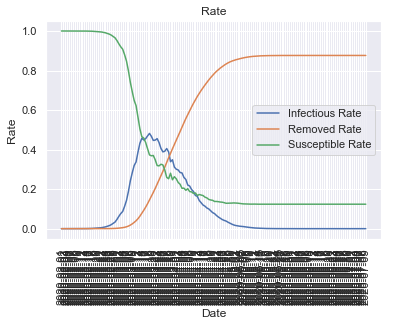

--------------------------------------------------------
first beta=2.7777599509650218e-06, first gamma=0.0
last beta=1.6609039394933438e-07, last gamma=0.50562


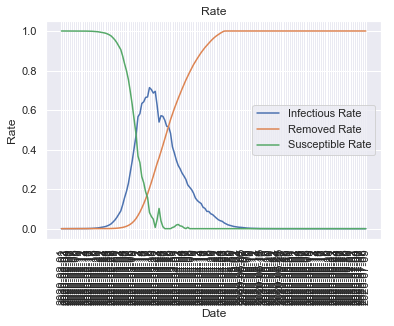

--------------------------------------------------------
first beta=2.8078896087722487e-06, first gamma=0.0
last beta=6.693651675847089e-08, last gamma=0.50562


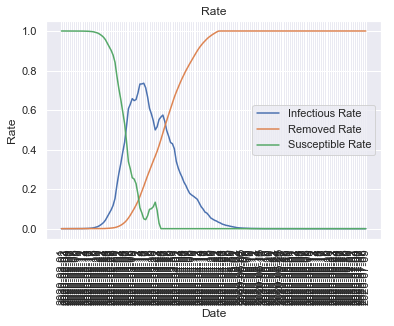

--------------------------------------------------------
first beta=2.3893538526719913e-06, first gamma=0.0
last beta=7.145606957775552e-08, last gamma=0.50562


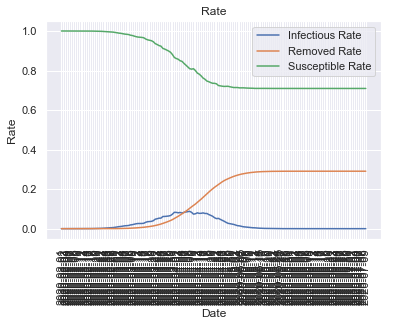

--------------------------------------------------------
first beta=3.254584204203856e-06, first gamma=0.0
last beta=7.377315497551776e-08, last gamma=0.50562


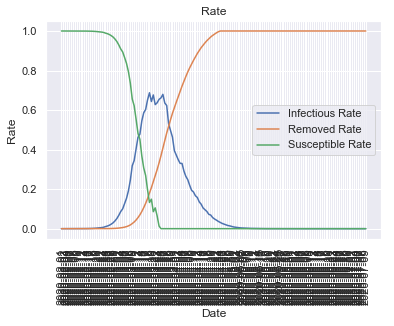

--------------------------------------------------------
first beta=2.7776070412537375e-06, first gamma=0.0
last beta=1.1591681493593291e-07, last gamma=0.50562


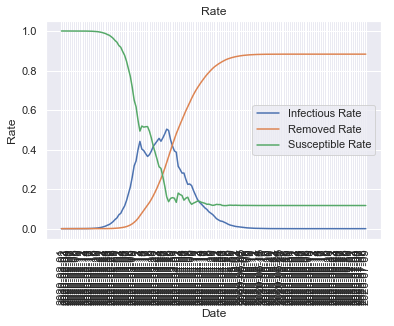

--------------------------------------------------------
first beta=3.037895739049206e-06, first gamma=0.0
last beta=1.4162877250305975e-07, last gamma=0.50562


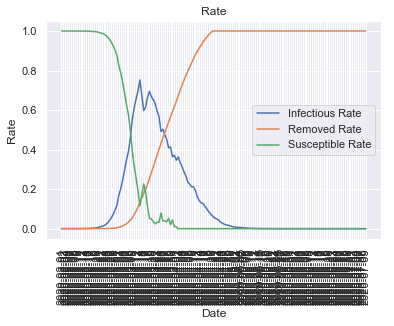

--------------------------------------------------------
first beta=3.317938858704834e-06, first gamma=0.0
last beta=9.35913752803e-08, last gamma=0.50562


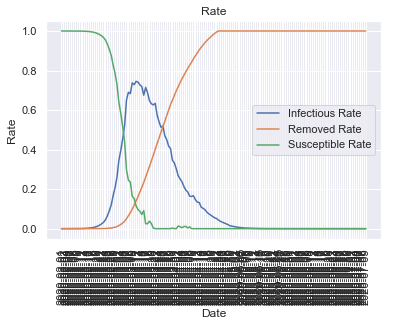

--------------------------------------------------------
first beta=2.734648007640077e-06, first gamma=0.0
last beta=9.872634991061725e-08, last gamma=0.50562


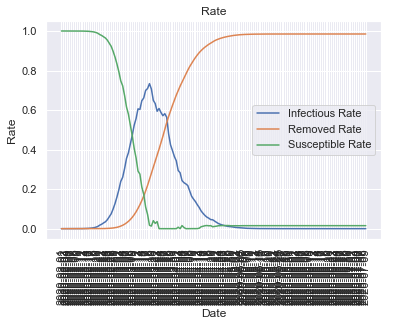

--------------------------------------------------------
first beta=3.1641994397167596e-06, first gamma=0.0
last beta=1.3075475969005692e-07, last gamma=0.50562


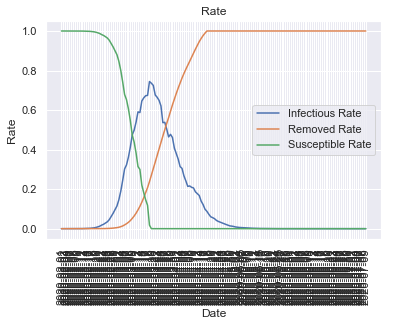

--------------------------------------------------------
first beta=3.216078301316278e-06, first gamma=0.0
last beta=9.700394680102027e-08, last gamma=0.50562


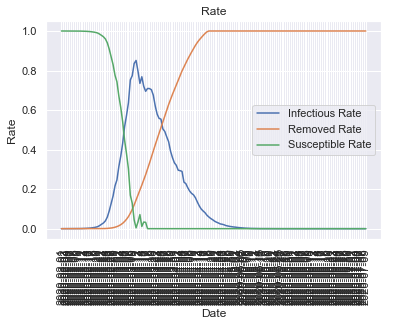

--------------------------------------------------------
first beta=3.238555545103471e-06, first gamma=0.0
last beta=2.0854295945894357e-07, last gamma=0.50562


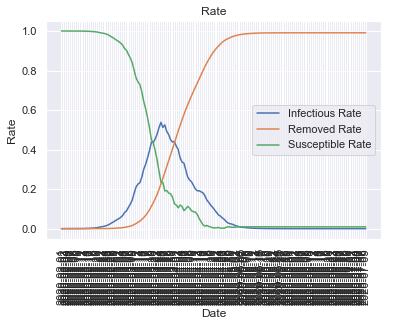

--------------------------------------------------------
first beta=2.7128283309853638e-06, first gamma=0.0
last beta=1.6604797609058572e-07, last gamma=0.50562


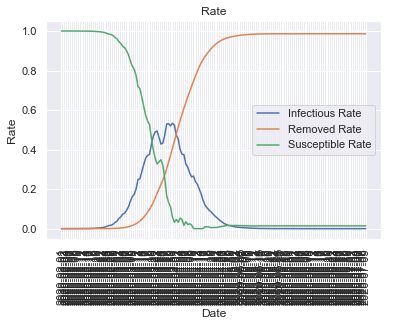

--------------------------------------------------------
first beta=2.9764481466707797e-06, first gamma=0.0
last beta=7.928325479396096e-08, last gamma=0.50562


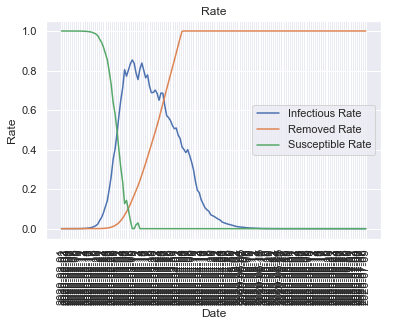

--------------------------------------------------------
first beta=2.748180718054673e-06, first gamma=0.0
last beta=1.4954623694196003e-07, last gamma=0.50562


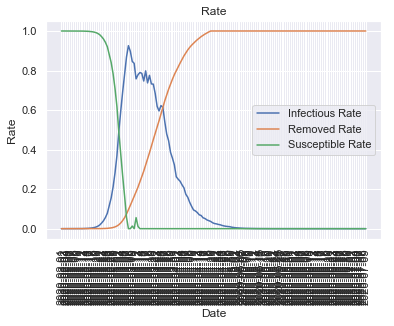

--------------------------------------------------------
first beta=2.9493014577321104e-06, first gamma=0.0
last beta=1.1212516301802729e-07, last gamma=0.50562


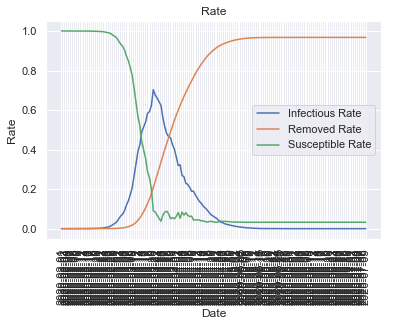

--------------------------------------------------------
first beta=2.5968109024081126e-06, first gamma=0.0
last beta=5.240444559075091e-08, last gamma=0.50562


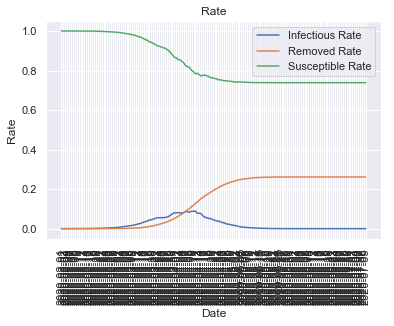

--------------------------------------------------------
first beta=2.93981959931885e-06, first gamma=0.0
last beta=9.769188108988889e-08, last gamma=0.50562


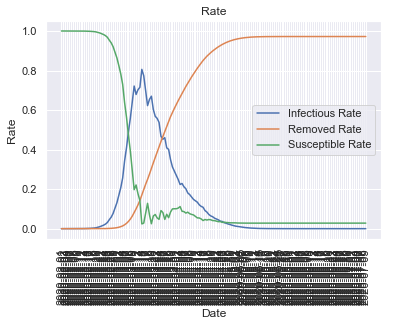

--------------------------------------------------------
first beta=2.4427328200397076e-06, first gamma=0.0
last beta=1.1808808861240407e-07, last gamma=0.50562


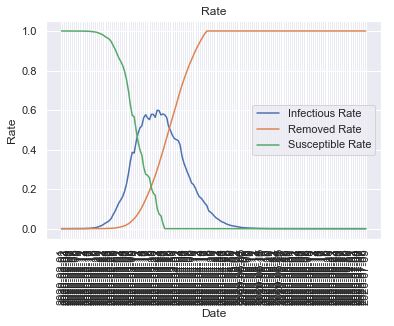

--------------------------------------------------------
first beta=3.1242411626476186e-06, first gamma=0.0
last beta=7.932797419604377e-08, last gamma=0.50562


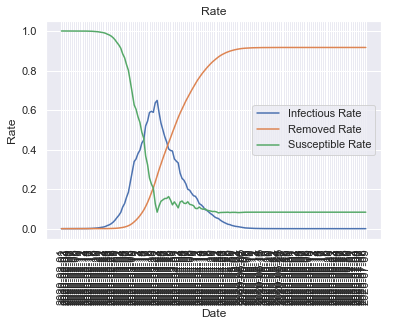

--------------------------------------------------------
first beta=3.462468074582265e-06, first gamma=0.0
last beta=1.7999818138886948e-07, last gamma=0.50562


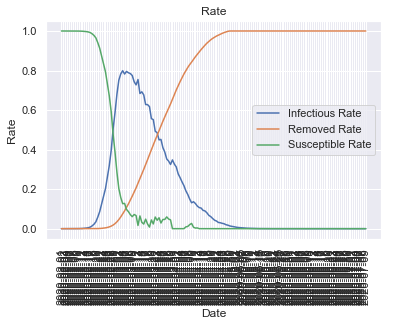

--------------------------------------------------------
first beta=3.428148699094078e-06, first gamma=0.0
last beta=1.4815848484630355e-07, last gamma=0.50562


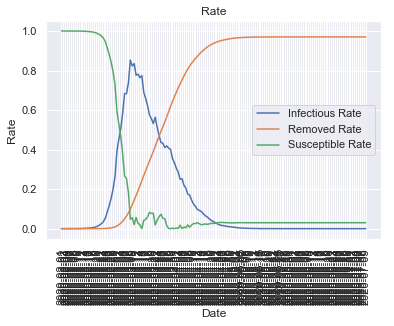

--------------------------------------------------------
first beta=3.469595703312988e-06, first gamma=0.0
last beta=1.3350717919292766e-07, last gamma=0.50562


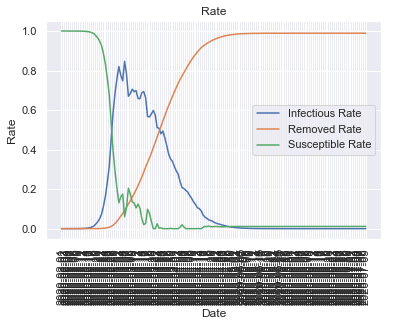

--------------------------------------------------------
first beta=3.098487842233387e-06, first gamma=0.0
last beta=1.267244699241974e-07, last gamma=0.50562


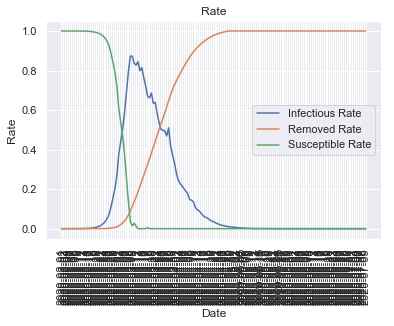

--------------------------------------------------------
first beta=2.511423020457661e-06, first gamma=0.0
last beta=6.533179195817079e-08, last gamma=0.50562


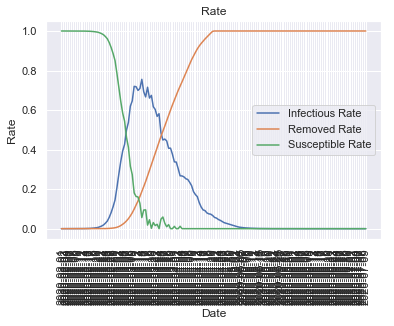

--------------------------------------------------------
first beta=2.7069242404528015e-06, first gamma=0.0
last beta=1.7237531527835195e-07, last gamma=0.50562


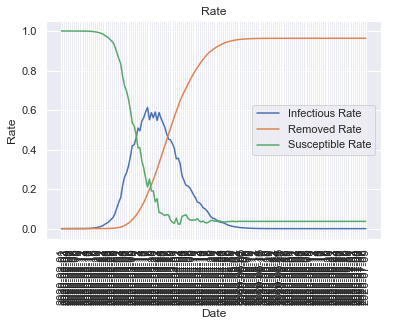

--------------------------------------------------------
first beta=2.7146236171194908e-06, first gamma=0.0
last beta=1.0293560915732631e-07, last gamma=0.50562


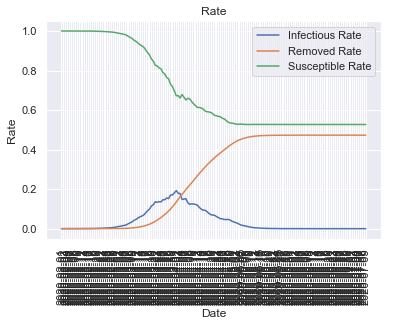

--------------------------------------------------------
first beta=3.3619024573933946e-06, first gamma=0.0
last beta=9.772324860397312e-08, last gamma=0.50562


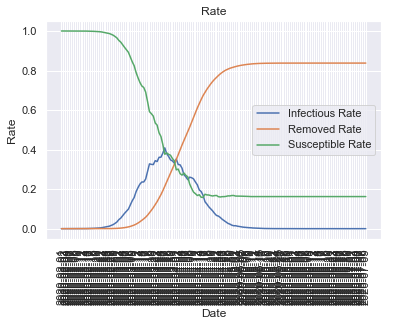

--------------------------------------------------------
first beta=3.394507881836579e-06, first gamma=0.0
last beta=1.6962587696457665e-07, last gamma=0.50562


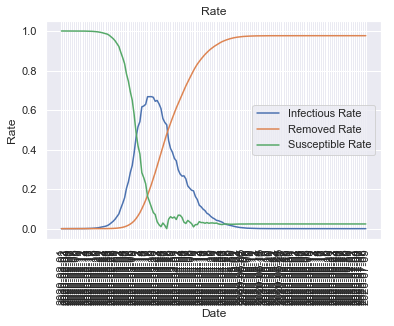

--------------------------------------------------------
first beta=3.04451497483968e-06, first gamma=0.0
last beta=1.5965902273273002e-07, last gamma=0.50562


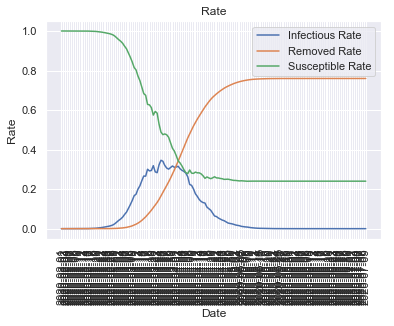

--------------------------------------------------------
first beta=2.8111140382043814e-06, first gamma=0.0
last beta=8.308187924567342e-08, last gamma=0.50562


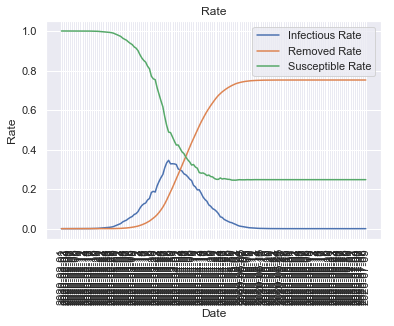

--------------------------------------------------------
first beta=2.9178413511914405e-06, first gamma=0.0
last beta=2.0624298667020784e-07, last gamma=0.50562


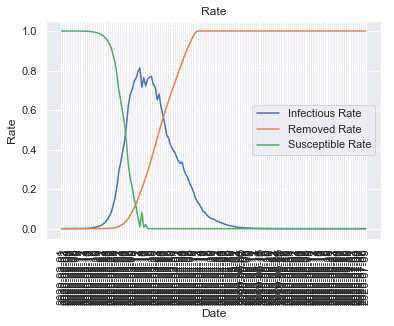

--------------------------------------------------------
first beta=3.125795131486734e-06, first gamma=0.0
last beta=1.9388264926590451e-07, last gamma=0.50562


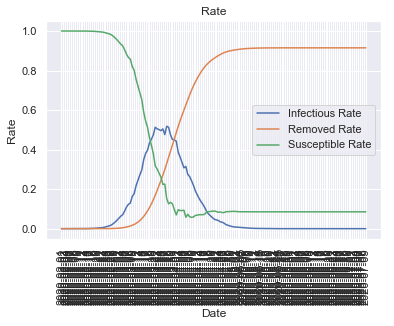

--------------------------------------------------------
first beta=2.6311004887928336e-06, first gamma=0.0
last beta=1.6914084905242665e-07, last gamma=0.50562


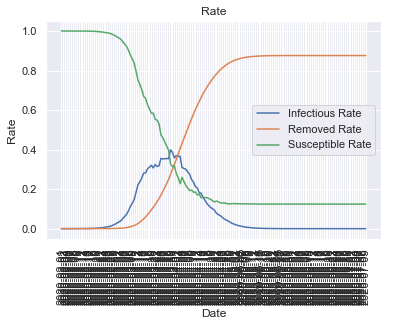

--------------------------------------------------------
first beta=2.4801741134370732e-06, first gamma=0.0
last beta=1.6464510482389125e-07, last gamma=0.50562


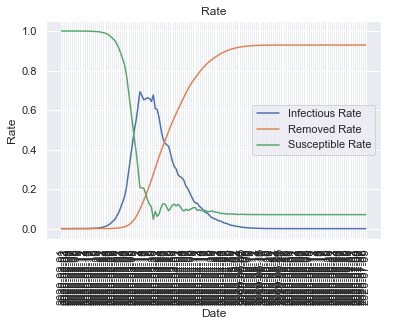

--------------------------------------------------------
first beta=2.7428271395050782e-06, first gamma=0.0
last beta=1.5239971413567918e-07, last gamma=0.50562


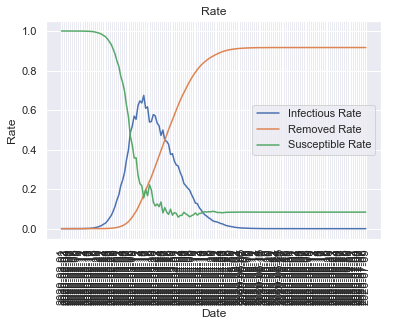

--------------------------------------------------------
first beta=3.2839434631930585e-06, first gamma=0.0
last beta=2.3353872170454568e-07, last gamma=0.50562


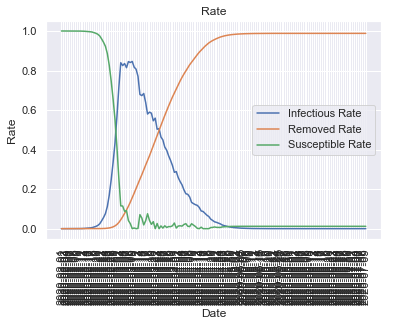

--------------------------------------------------------
first beta=3.4086383505717687e-06, first gamma=0.0
last beta=5.7383921874163714e-08, last gamma=0.50562


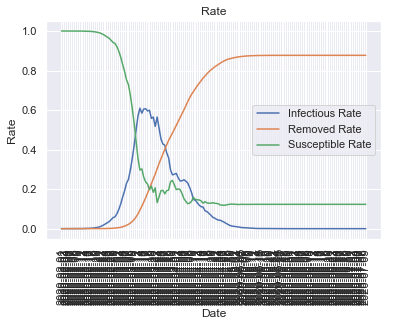

--------------------------------------------------------
first beta=2.96547894719371e-06, first gamma=0.0
last beta=3.3094017555428843e-07, last gamma=0.50562


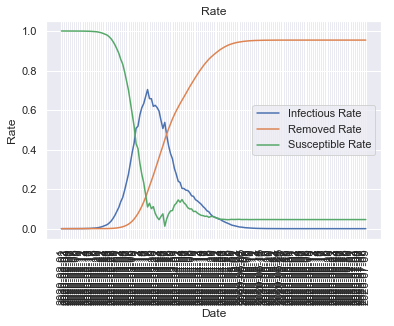

--------------------------------------------------------
first beta=2.515574035303381e-06, first gamma=0.0
last beta=8.92429498904631e-08, last gamma=0.50562


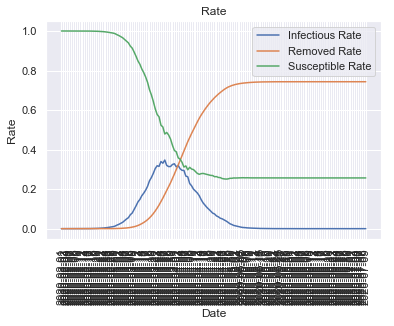

--------------------------------------------------------
first beta=3.2401393269506986e-06, first gamma=0.0
last beta=1.4833708730170166e-07, last gamma=0.50562


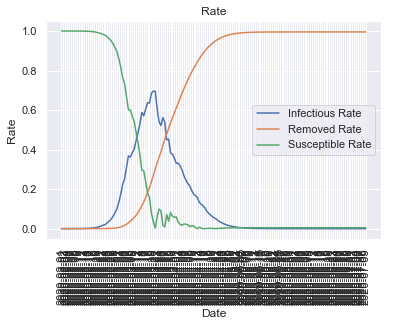

--------------------------------------------------------
first beta=2.702238445603999e-06, first gamma=0.0
last beta=1.1682708996215264e-07, last gamma=0.50562


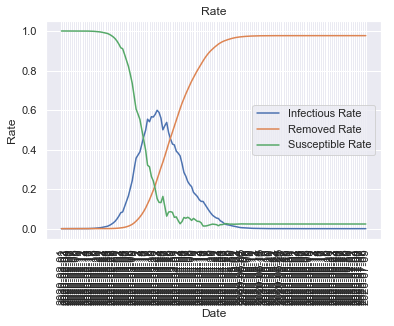

--------------------------------------------------------
first beta=2.7985369378331137e-06, first gamma=0.0
last beta=1.4706787547625126e-07, last gamma=0.50562


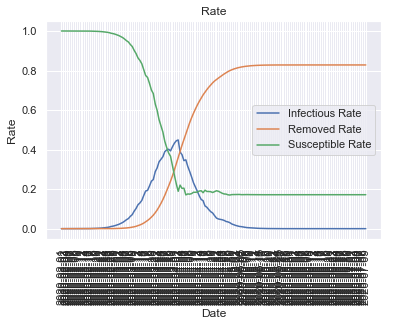

--------------------------------------------------------
first beta=2.4760139543879124e-06, first gamma=0.0
last beta=3.833705387088577e-07, last gamma=0.50562


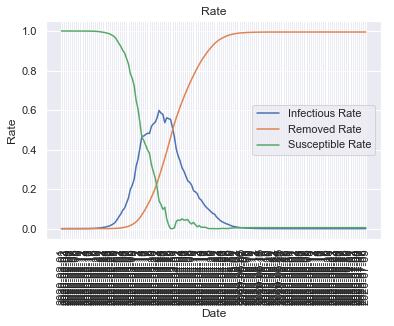

--------------------------------------------------------
first beta=2.738358813372567e-06, first gamma=0.0
last beta=1.6620103057472826e-07, last gamma=0.50562


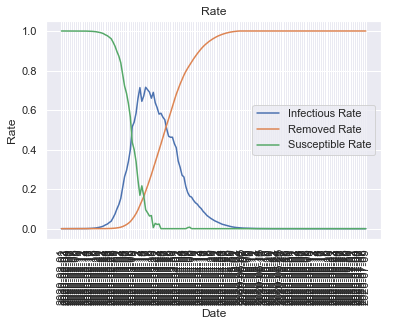

--------------------------------------------------------
first beta=2.4282824764114302e-06, first gamma=0.0
last beta=1.780886503123071e-07, last gamma=0.50562


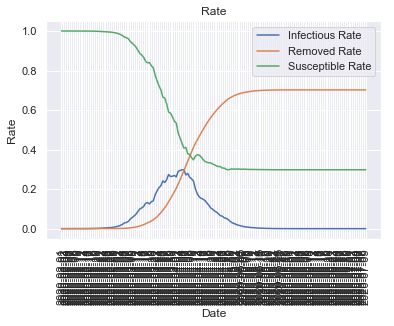

In [53]:
# Small Noise
for i in range(100):
    # Total population, N.
    N = 200000
    # Initial number of infected and recovered individuals, I0 and R0.
    I, R = 1, 0.0
    # Everyone else, S0, is susceptible to infection initially.
    S = N - I - R
    t = np.linspace(0, days, days)

    # Initial conditions vector
    y = S, I, R

    # Static
    # beta = random.uniform(1e-7, 5e-6)
    # gamma = 0.1
    # # Integrate the SIR equations over the time grid, t.
    # ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    # S, I, R = ret.T
    # sir_df = pd.DataFrame({
    #     'Code': "SIR-{}".format(i),
    #     'confirmed': I,
    #     'removed': R,
    #     'susceptible': S,
    #     'infectious_rate': I/N,
    #     'removed_rate': R/N,
    #     'susceptible_rate': S/N
    # })

    # Dynamic
    beta = random.uniform(2.3e-6, 3.5e-6)
    # gamma = 0.1
    sir_df = pd.DataFrame(index=[], columns=cols)
    sus, inf, rec= [],[],[]
    print("--------------------------------------------------------")
    print("first beta={}, first gamma={}".format(beta, gamma(0)))
    for day in range(days):
        if day % 10 == 0:
            beta = beta * random.uniform(0.66, 1)
        sus.append(S)
        inf.append(I)
        rec.append(R)
#         S_ = S
#         I_ = I
#         R_ = R
#         I = I_ + beta * S_ * I_ - gamma(day) * I_ + I_*0.3*np.random.normal(loc=0, scale=1)
#         R = R_ + gamma(day) * I_
#         S = N - I - R
        S_ = S
        I_ = I *(1 - 0.05*np.random.normal(loc=0, scale=1))
        R_ = R
        I = max(I_ + beta * S_ * I_ - gamma(day) * I_, 0) 
        R = max(R_ + gamma(day) * I_, 0)
        S = max(N - I - R,0)
        I = min(I, N)
        R = min(R, N)
    sir_df["confirmed"] = inf
    sir_df["removed"] = rec
    sir_df["susceptible"] = sus
    sir_df["infectious_rate"] = (np.array(inf)/N).tolist()
    sir_df["removed_rate"] = (np.array(rec)/N).tolist()
    sir_df["susceptible_rate"] = (np.array(sus)/N).tolist()
    sir_df["Code"] = "SIR-small-{}".format(i)

    # Rate change
    sir_df["infectious_rate_change"] = sir_df["infectious_rate"].pct_change()
    sir_df["infectious_rate_change"] = sir_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    sir_df["removed_rate_change"] = sir_df["removed_rate"].pct_change()
    sir_df["removed_rate_change"] = sir_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    sir_df["susceptible_rate_change"] = sir_df["susceptible_rate"].pct_change()
    sir_df["susceptible_rate_change"] = sir_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Add Date
    sir_df["Date"] = dates

    print("last beta={}, last gamma={}".format(beta, gamma(days-1)))
    display_rate(sir_df)
    SIR_df = pd.concat([SIR_df, sir_df])

--------------------------------------------------------
first beta=3.3214696469512126e-06, first gamma=0.0
last beta=1.7930418381406452e-07, last gamma=0.50562


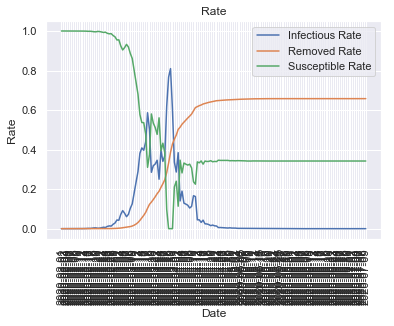

--------------------------------------------------------
first beta=2.6225762297263737e-06, first gamma=0.0
last beta=2.2543430398161033e-07, last gamma=0.50562


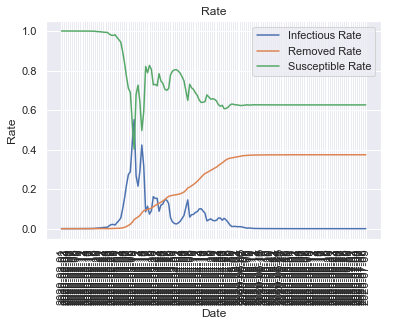

--------------------------------------------------------
first beta=3.077299802124137e-06, first gamma=0.0
last beta=9.517093691495295e-08, last gamma=0.50562


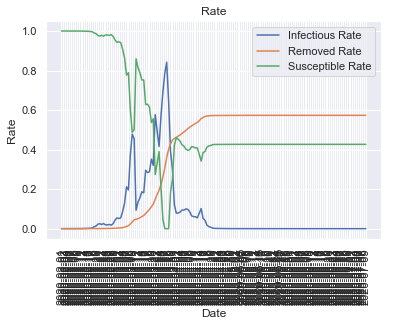

--------------------------------------------------------
first beta=2.354937132731475e-06, first gamma=0.0
last beta=4.509668709892329e-08, last gamma=0.50562


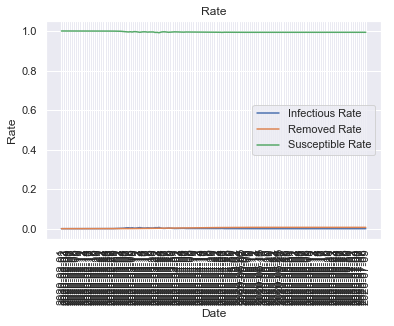

--------------------------------------------------------
first beta=3.143817878911662e-06, first gamma=0.0
last beta=1.8445527241119776e-07, last gamma=0.50562


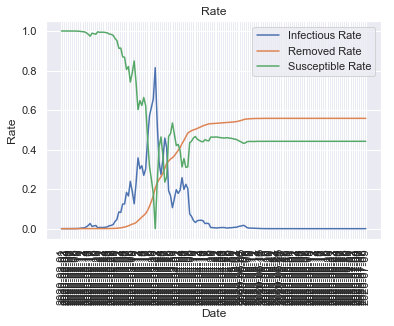

--------------------------------------------------------
first beta=3.4178939333010904e-06, first gamma=0.0
last beta=1.8316177870564975e-07, last gamma=0.50562


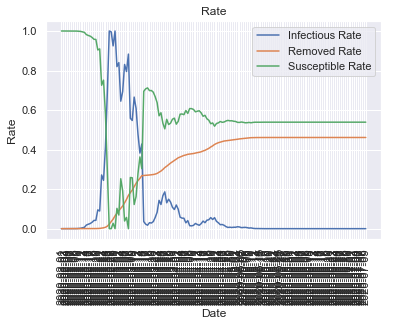

--------------------------------------------------------
first beta=3.3730553879082285e-06, first gamma=0.0
last beta=4.247960331151062e-07, last gamma=0.50562


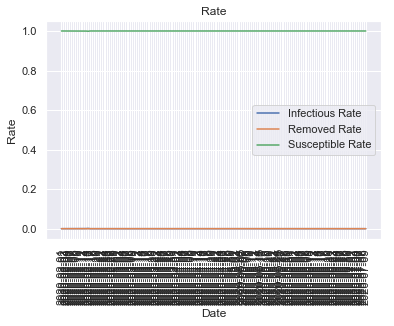

--------------------------------------------------------
first beta=2.6772268792735694e-06, first gamma=0.0
last beta=5.82118811652998e-08, last gamma=0.50562


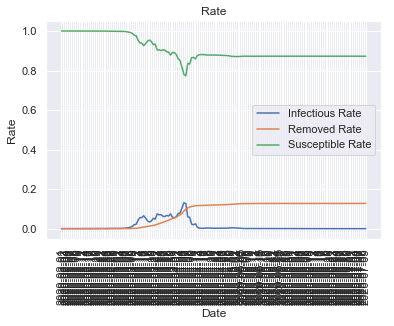

--------------------------------------------------------
first beta=3.102743070039447e-06, first gamma=0.0
last beta=1.9566639423145678e-07, last gamma=0.50562


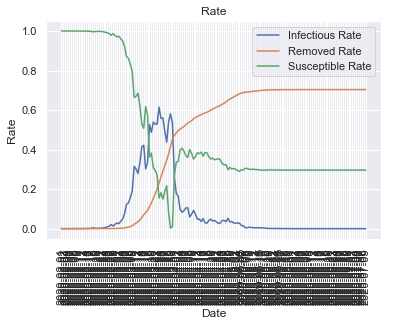

--------------------------------------------------------
first beta=2.865105096393806e-06, first gamma=0.0
last beta=1.325155264490734e-07, last gamma=0.50562


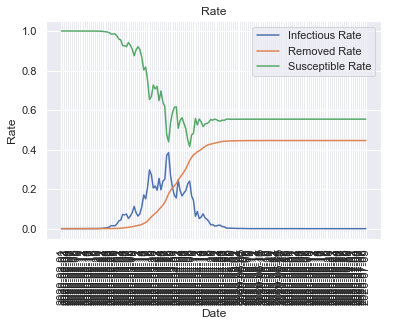

--------------------------------------------------------
first beta=2.4956676199845014e-06, first gamma=0.0
last beta=6.05591134189607e-08, last gamma=0.50562


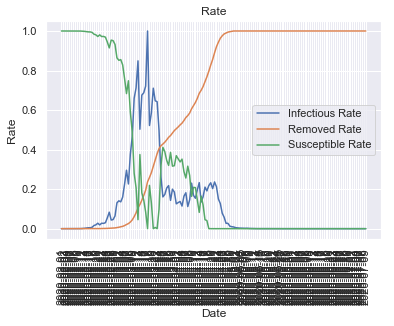

--------------------------------------------------------
first beta=3.225510053322762e-06, first gamma=0.0
last beta=2.0524077969934137e-07, last gamma=0.50562


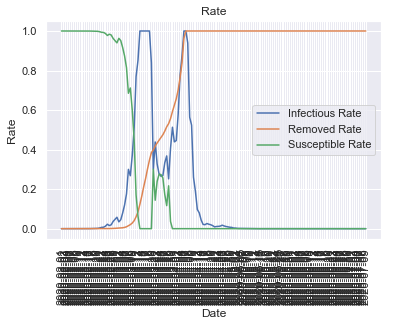

--------------------------------------------------------
first beta=3.445059008341965e-06, first gamma=0.0
last beta=2.7927148806795495e-07, last gamma=0.50562


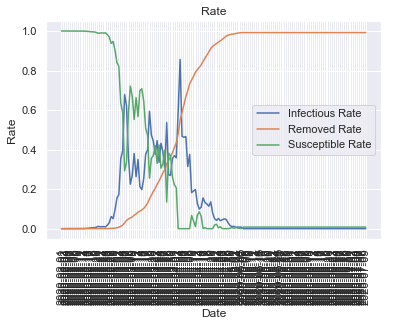

--------------------------------------------------------
first beta=2.810688224982852e-06, first gamma=0.0
last beta=7.643324803931851e-08, last gamma=0.50562


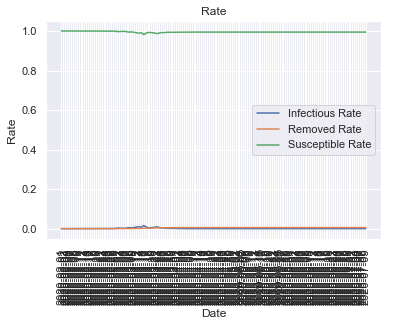

--------------------------------------------------------
first beta=3.2472130929363493e-06, first gamma=0.0
last beta=1.229952585820705e-07, last gamma=0.50562


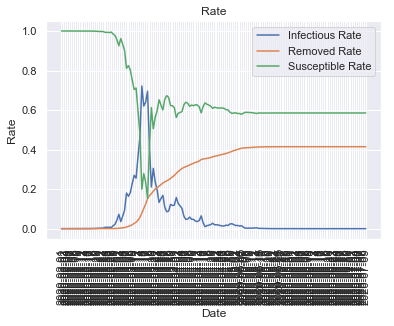

--------------------------------------------------------
first beta=2.312638814185409e-06, first gamma=0.0
last beta=2.6581969102721323e-07, last gamma=0.50562


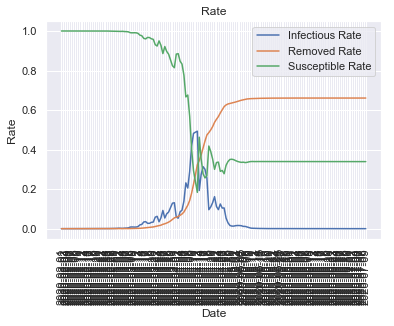

--------------------------------------------------------
first beta=2.871007228418687e-06, first gamma=0.0
last beta=1.0132255679296495e-07, last gamma=0.50562


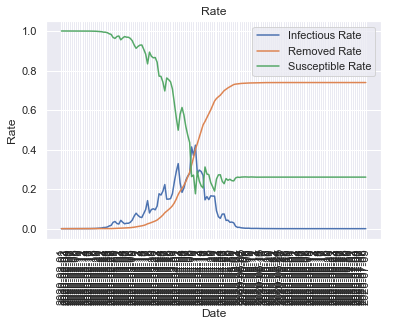

--------------------------------------------------------
first beta=3.1335271513054495e-06, first gamma=0.0
last beta=1.7146895799870506e-07, last gamma=0.50562


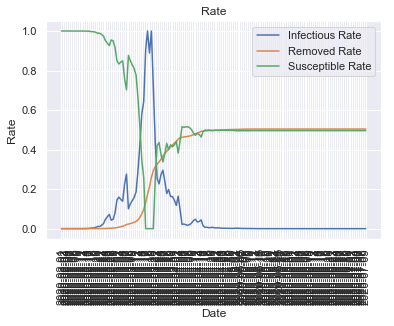

--------------------------------------------------------
first beta=2.662771909732904e-06, first gamma=0.0
last beta=9.747300214408464e-08, last gamma=0.50562


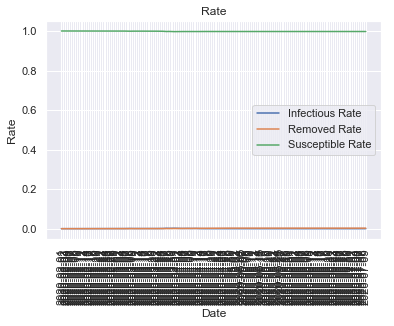

--------------------------------------------------------
first beta=2.388410739502765e-06, first gamma=0.0
last beta=1.3996712259973953e-07, last gamma=0.50562


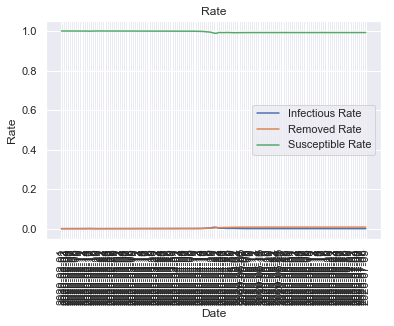

--------------------------------------------------------
first beta=3.106182743736973e-06, first gamma=0.0
last beta=8.606783112111791e-08, last gamma=0.50562


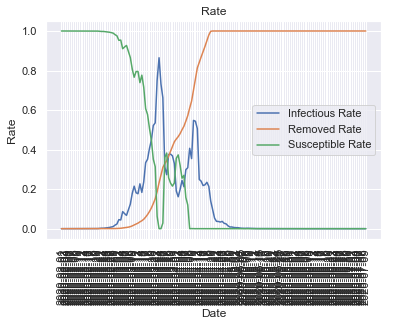

--------------------------------------------------------
first beta=3.3344966791279235e-06, first gamma=0.0
last beta=1.8014296830217685e-07, last gamma=0.50562


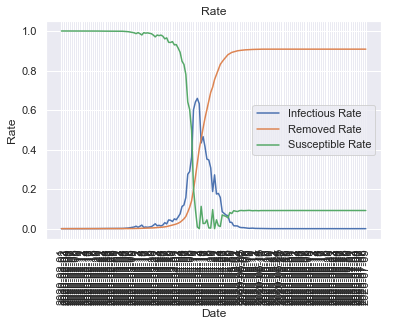

--------------------------------------------------------
first beta=2.5144975317798487e-06, first gamma=0.0
last beta=1.0416886465747487e-07, last gamma=0.50562


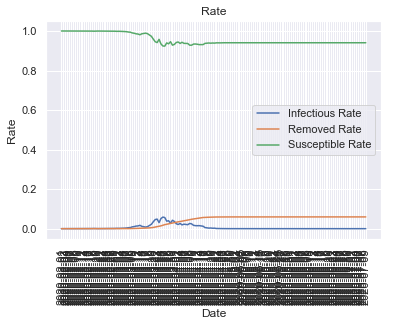

--------------------------------------------------------
first beta=2.427201857808114e-06, first gamma=0.0
last beta=5.99595829566586e-08, last gamma=0.50562


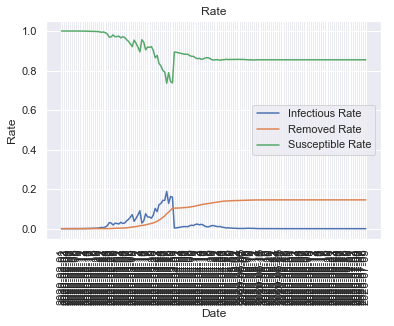

--------------------------------------------------------
first beta=3.2075668320022696e-06, first gamma=0.0
last beta=2.531811651798714e-07, last gamma=0.50562


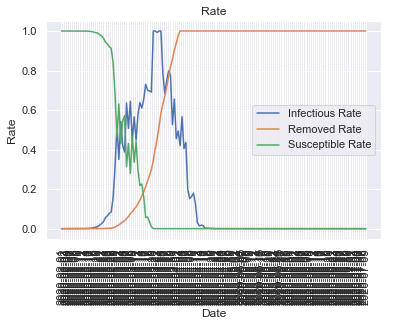

--------------------------------------------------------
first beta=3.180329182073696e-06, first gamma=0.0
last beta=6.383705321352683e-08, last gamma=0.50562


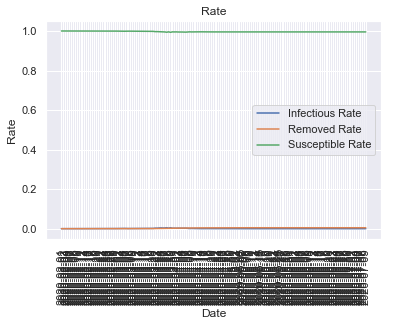

--------------------------------------------------------
first beta=2.3853355404596916e-06, first gamma=0.0
last beta=9.682560425581447e-08, last gamma=0.50562


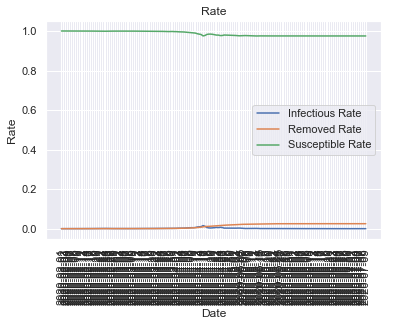

--------------------------------------------------------
first beta=2.8952011994884158e-06, first gamma=0.0
last beta=2.1534589975554786e-07, last gamma=0.50562


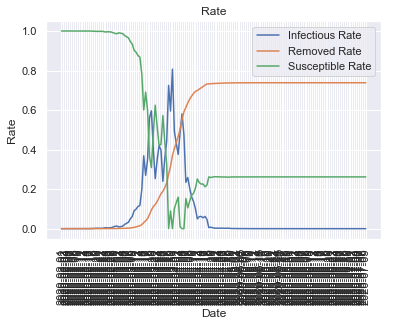

--------------------------------------------------------
first beta=3.4278080792728613e-06, first gamma=0.0
last beta=1.7772785958636677e-07, last gamma=0.50562


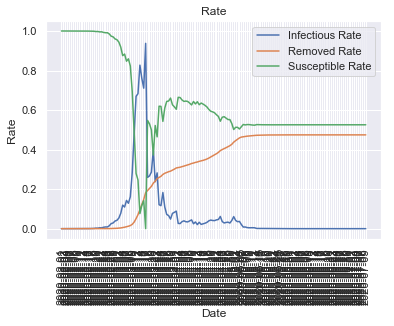

--------------------------------------------------------
first beta=2.594703120337758e-06, first gamma=0.0
last beta=5.535156428365698e-08, last gamma=0.50562


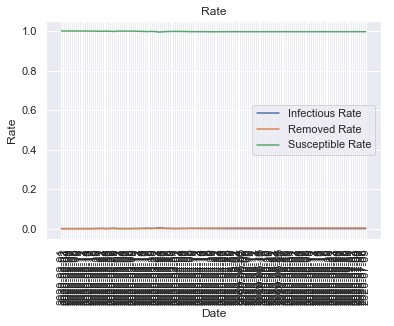

--------------------------------------------------------
first beta=2.6582420848527496e-06, first gamma=0.0
last beta=2.7452489169467825e-07, last gamma=0.50562


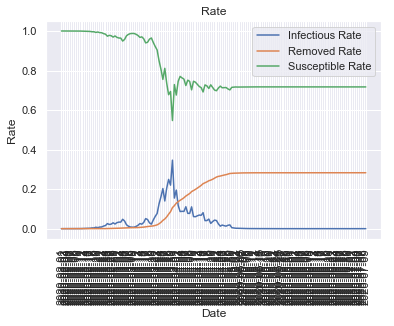

--------------------------------------------------------
first beta=3.166940584699778e-06, first gamma=0.0
last beta=1.231087726996095e-07, last gamma=0.50562


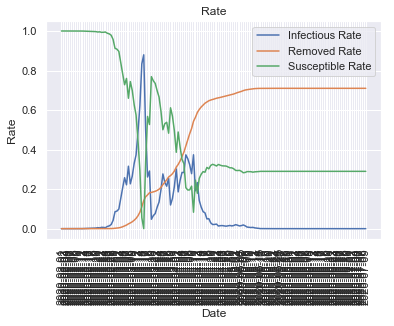

--------------------------------------------------------
first beta=3.1380781636825465e-06, first gamma=0.0
last beta=1.0467989878905858e-07, last gamma=0.50562


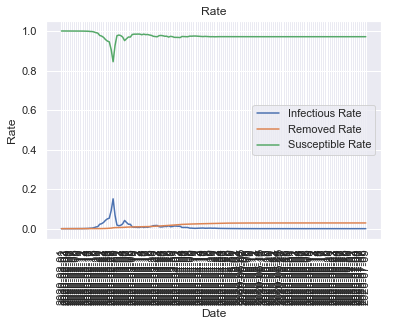

--------------------------------------------------------
first beta=2.894073169584104e-06, first gamma=0.0
last beta=9.431546956120708e-08, last gamma=0.50562


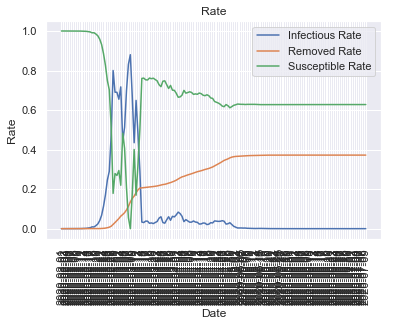

--------------------------------------------------------
first beta=3.4741027144188017e-06, first gamma=0.0
last beta=2.0506786280629458e-07, last gamma=0.50562


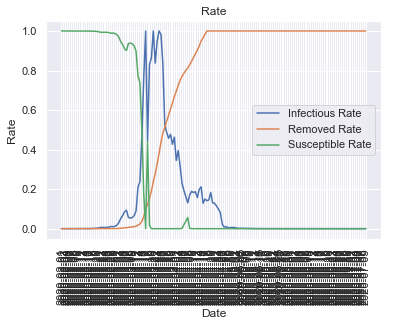

--------------------------------------------------------
first beta=3.0741112206063146e-06, first gamma=0.0
last beta=1.0458809807417181e-07, last gamma=0.50562


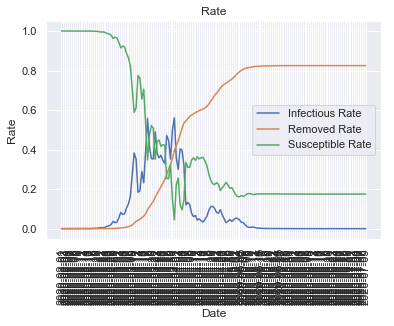

--------------------------------------------------------
first beta=2.452249370058839e-06, first gamma=0.0
last beta=8.35371826653231e-08, last gamma=0.50562


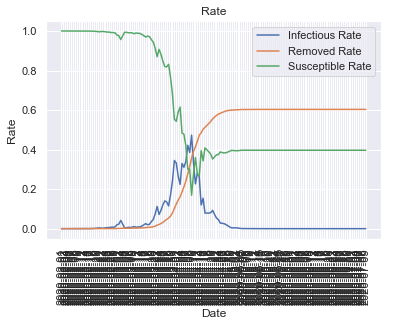

--------------------------------------------------------
first beta=3.2223112459867054e-06, first gamma=0.0
last beta=1.4112803050343741e-07, last gamma=0.50562


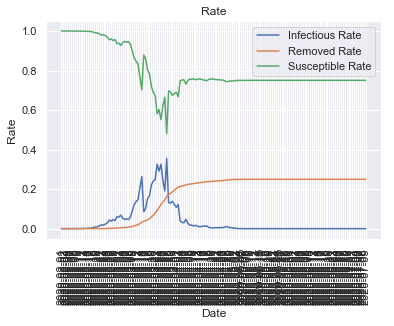

--------------------------------------------------------
first beta=2.629424240245917e-06, first gamma=0.0
last beta=2.149061879960481e-07, last gamma=0.50562


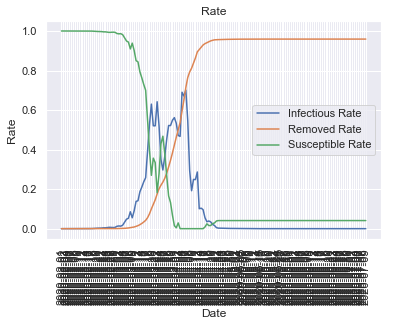

--------------------------------------------------------
first beta=2.903791563753617e-06, first gamma=0.0
last beta=5.237405383307784e-08, last gamma=0.50562


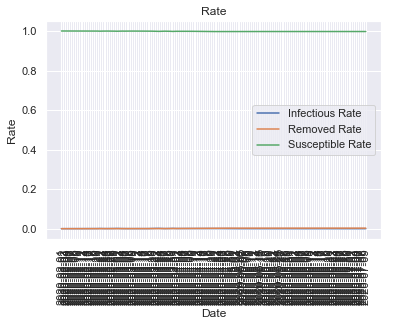

--------------------------------------------------------
first beta=2.601096942092253e-06, first gamma=0.0
last beta=8.152338351846541e-08, last gamma=0.50562


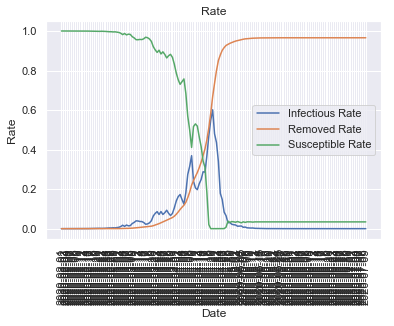

--------------------------------------------------------
first beta=3.1773242798323917e-06, first gamma=0.0
last beta=2.3976266594828637e-07, last gamma=0.50562


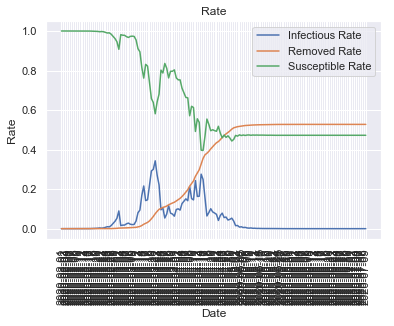

--------------------------------------------------------
first beta=2.910882295160449e-06, first gamma=0.0
last beta=1.2833100333869867e-07, last gamma=0.50562


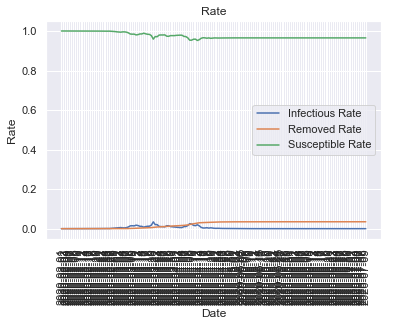

--------------------------------------------------------
first beta=2.409875983016462e-06, first gamma=0.0
last beta=6.402601292138869e-08, last gamma=0.50562


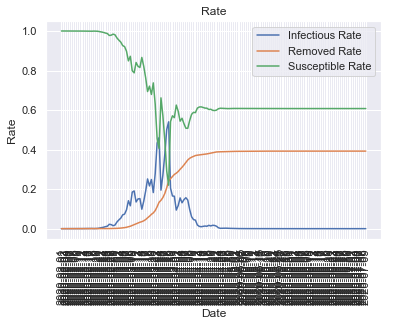

--------------------------------------------------------
first beta=2.772935275817258e-06, first gamma=0.0
last beta=8.406255721948889e-08, last gamma=0.50562


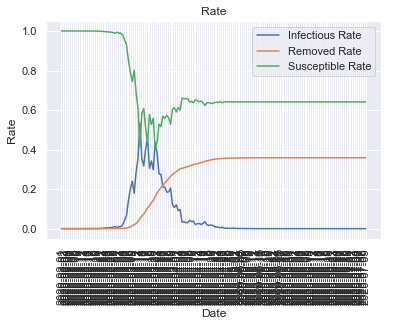

--------------------------------------------------------
first beta=3.30788653810062e-06, first gamma=0.0
last beta=2.8814155243739363e-07, last gamma=0.50562


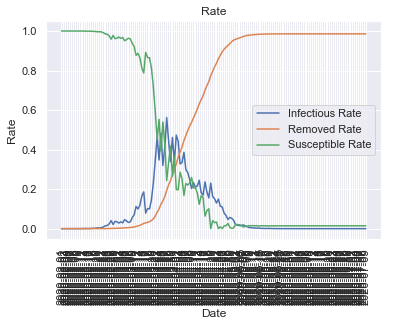

--------------------------------------------------------
first beta=2.9789663318776965e-06, first gamma=0.0
last beta=5.673540036287883e-08, last gamma=0.50562


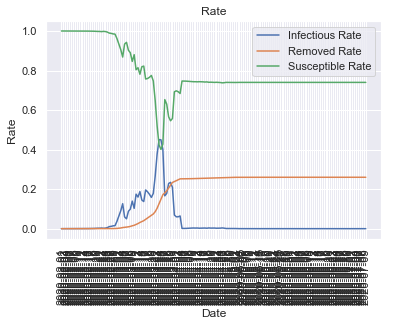

--------------------------------------------------------
first beta=3.247798957699771e-06, first gamma=0.0
last beta=2.0356132435696228e-07, last gamma=0.50562


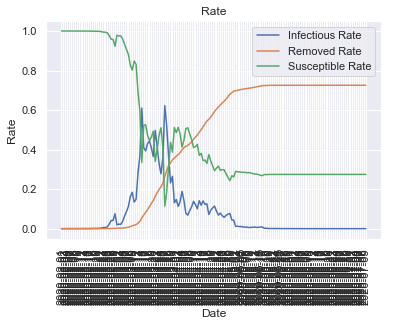

--------------------------------------------------------
first beta=2.8096502924625804e-06, first gamma=0.0
last beta=1.7129505266374675e-07, last gamma=0.50562


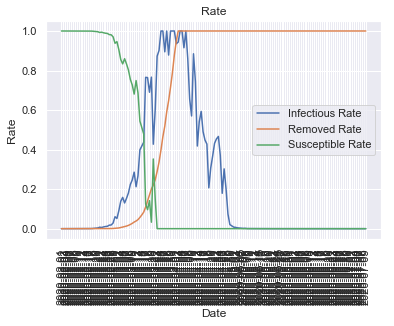

--------------------------------------------------------
first beta=3.1781453717348083e-06, first gamma=0.0
last beta=1.5804869318642437e-07, last gamma=0.50562


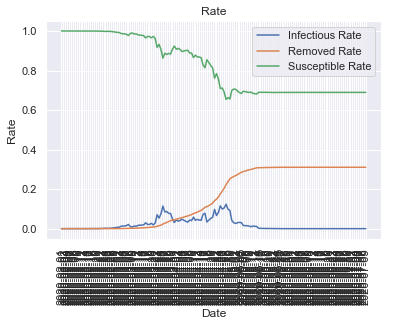

--------------------------------------------------------
first beta=2.4671859560280937e-06, first gamma=0.0
last beta=1.5755484515226341e-07, last gamma=0.50562


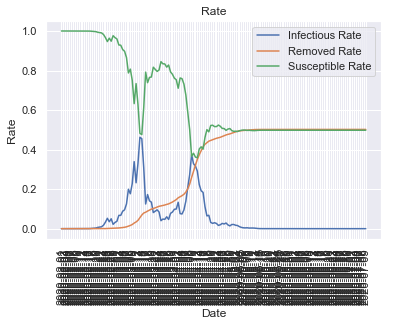

--------------------------------------------------------
first beta=2.398004122051372e-06, first gamma=0.0
last beta=1.1923296344347717e-07, last gamma=0.50562


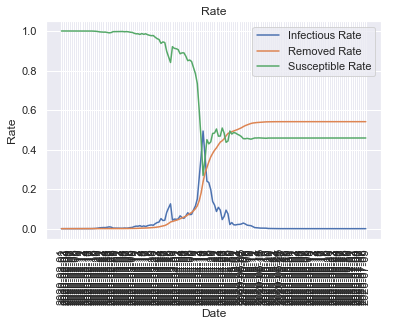

--------------------------------------------------------
first beta=3.4483281261031168e-06, first gamma=0.0
last beta=5.566171554600182e-08, last gamma=0.50562


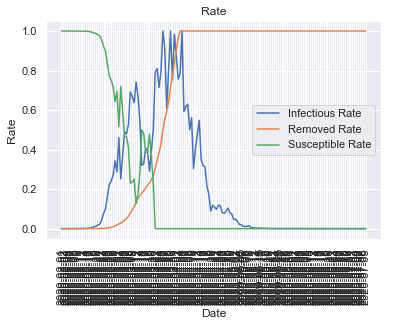

--------------------------------------------------------
first beta=2.5735268146667213e-06, first gamma=0.0
last beta=6.035439603227139e-08, last gamma=0.50562


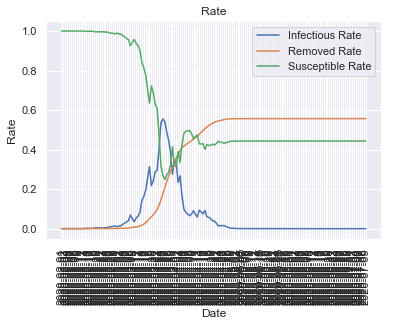

--------------------------------------------------------
first beta=3.0723059668763124e-06, first gamma=0.0
last beta=1.4276356121831177e-07, last gamma=0.50562


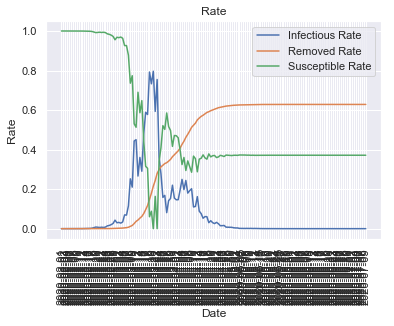

--------------------------------------------------------
first beta=3.271964218392142e-06, first gamma=0.0
last beta=1.133240954002282e-07, last gamma=0.50562


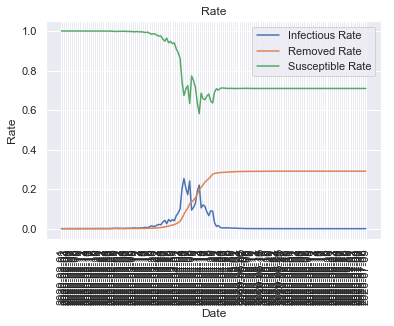

--------------------------------------------------------
first beta=2.536858212612329e-06, first gamma=0.0
last beta=2.539511761569706e-07, last gamma=0.50562


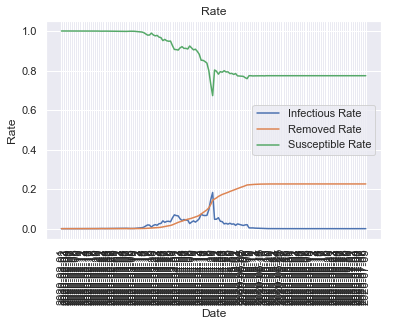

--------------------------------------------------------
first beta=3.0200128222696707e-06, first gamma=0.0
last beta=1.6108861376765073e-07, last gamma=0.50562


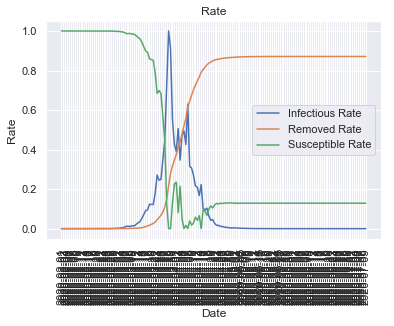

--------------------------------------------------------
first beta=3.4049652142864494e-06, first gamma=0.0
last beta=4.6644129122429084e-07, last gamma=0.50562


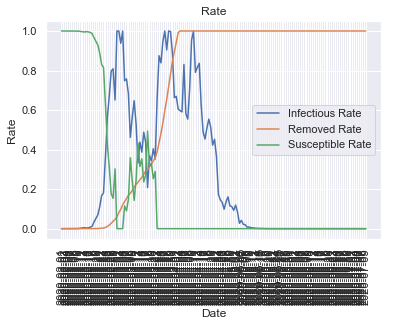

--------------------------------------------------------
first beta=2.436635464494972e-06, first gamma=0.0
last beta=1.421156791704751e-07, last gamma=0.50562


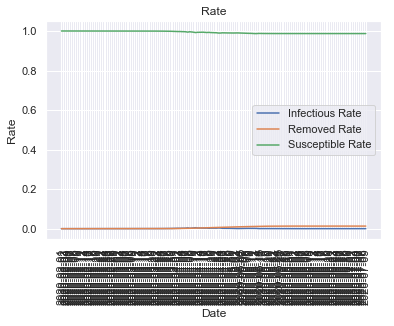

--------------------------------------------------------
first beta=3.3804761646295975e-06, first gamma=0.0
last beta=1.3499820885197736e-07, last gamma=0.50562


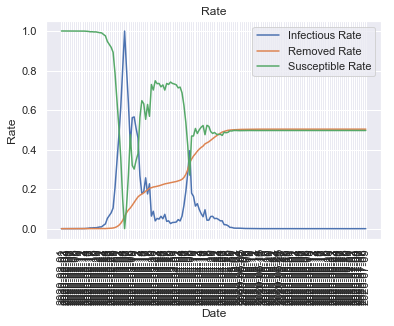

--------------------------------------------------------
first beta=3.3464044464259077e-06, first gamma=0.0
last beta=1.219212047366148e-07, last gamma=0.50562


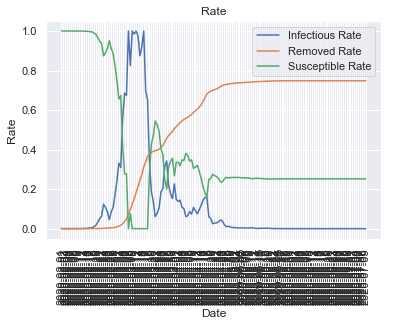

--------------------------------------------------------
first beta=2.7028694660570506e-06, first gamma=0.0
last beta=1.3167122916036464e-07, last gamma=0.50562


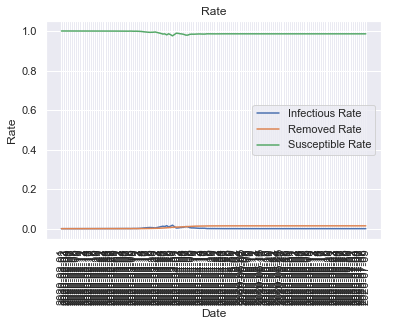

--------------------------------------------------------
first beta=3.3744665908470048e-06, first gamma=0.0
last beta=1.9066090453957178e-07, last gamma=0.50562


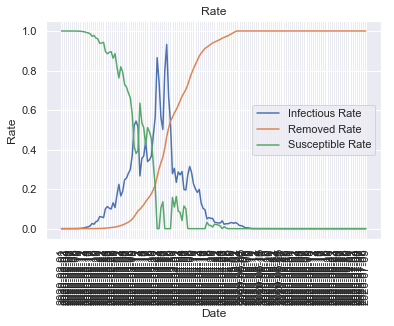

--------------------------------------------------------
first beta=2.4850058691536276e-06, first gamma=0.0
last beta=1.1411977662976468e-07, last gamma=0.50562


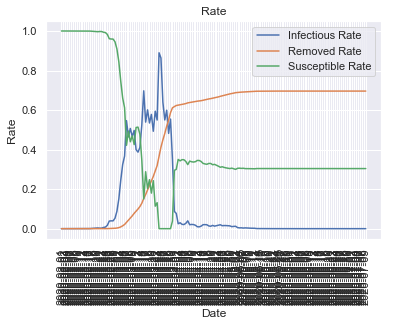

--------------------------------------------------------
first beta=2.94814704164001e-06, first gamma=0.0
last beta=1.0251174240582263e-07, last gamma=0.50562


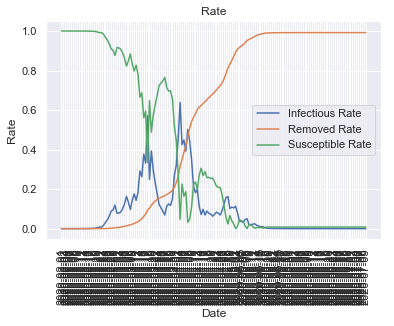

--------------------------------------------------------
first beta=2.7089393592673445e-06, first gamma=0.0
last beta=1.1507147521402823e-07, last gamma=0.50562


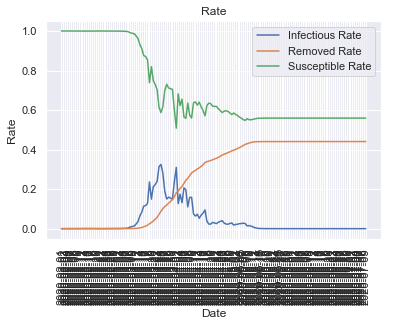

--------------------------------------------------------
first beta=3.0374950527519005e-06, first gamma=0.0
last beta=4.007354245482886e-07, last gamma=0.50562


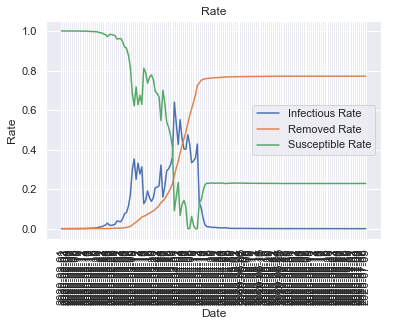

--------------------------------------------------------
first beta=2.8209884200226303e-06, first gamma=0.0
last beta=1.0327412249874436e-07, last gamma=0.50562


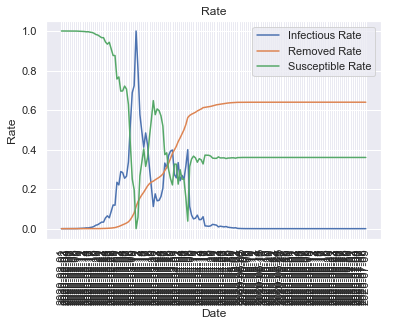

--------------------------------------------------------
first beta=2.305753964734752e-06, first gamma=0.0
last beta=5.279611590206964e-08, last gamma=0.50562


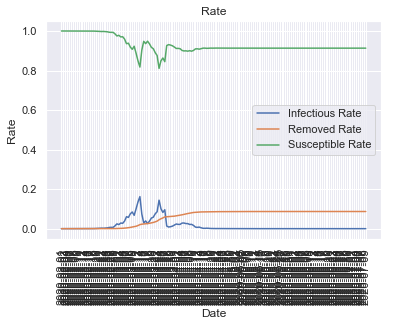

--------------------------------------------------------
first beta=2.8345652388626046e-06, first gamma=0.0
last beta=8.821610318504833e-08, last gamma=0.50562


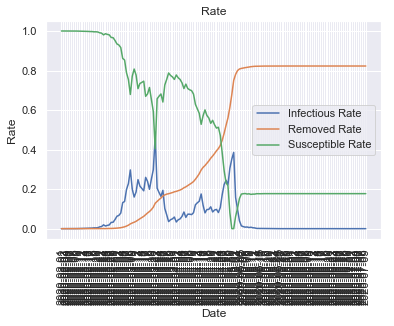

--------------------------------------------------------
first beta=3.008612036566992e-06, first gamma=0.0
last beta=1.2217755409282345e-07, last gamma=0.50562


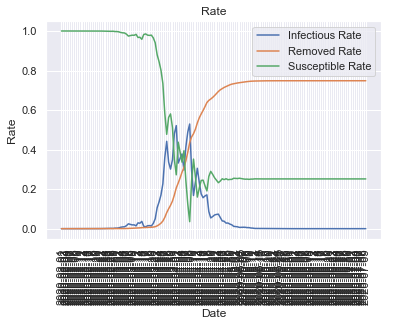

--------------------------------------------------------
first beta=3.4253970708036217e-06, first gamma=0.0
last beta=1.650430453956808e-07, last gamma=0.50562


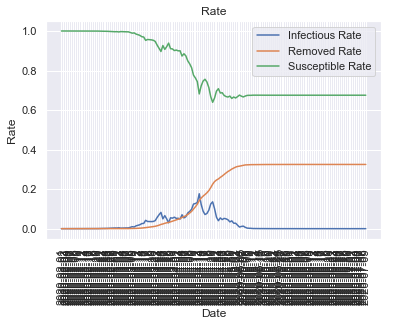

--------------------------------------------------------
first beta=2.8376536726691514e-06, first gamma=0.0
last beta=1.0224149497229694e-07, last gamma=0.50562


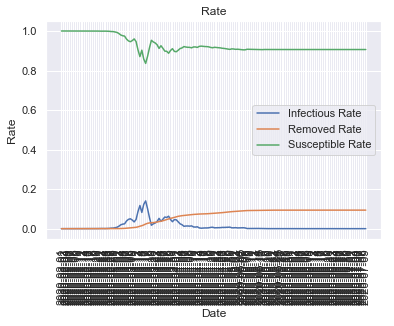

--------------------------------------------------------
first beta=3.038369876886934e-06, first gamma=0.0
last beta=1.3677615220663488e-07, last gamma=0.50562


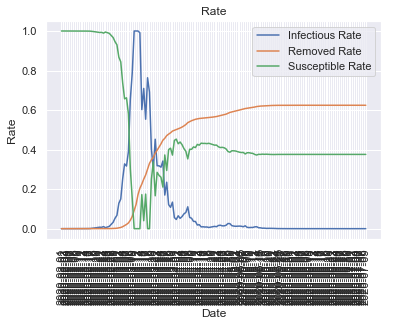

--------------------------------------------------------
first beta=2.8398888208907545e-06, first gamma=0.0
last beta=9.951383257604432e-08, last gamma=0.50562


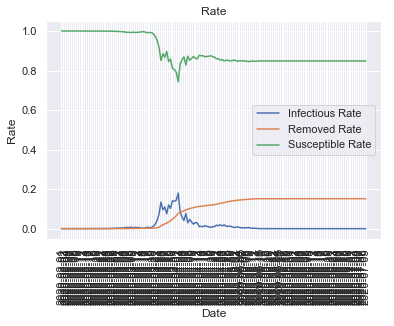

--------------------------------------------------------
first beta=3.113236984125411e-06, first gamma=0.0
last beta=8.032945269013692e-08, last gamma=0.50562


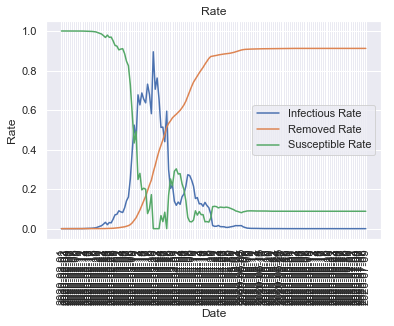

--------------------------------------------------------
first beta=2.771407220444273e-06, first gamma=0.0
last beta=2.7983240437378926e-07, last gamma=0.50562


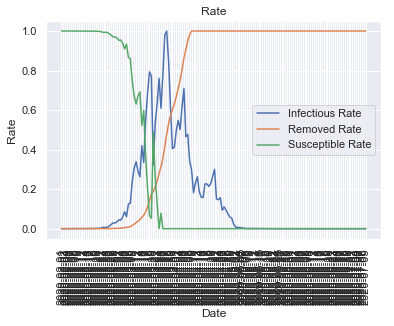

--------------------------------------------------------
first beta=3.1539263677294665e-06, first gamma=0.0
last beta=1.2352742067071913e-07, last gamma=0.50562


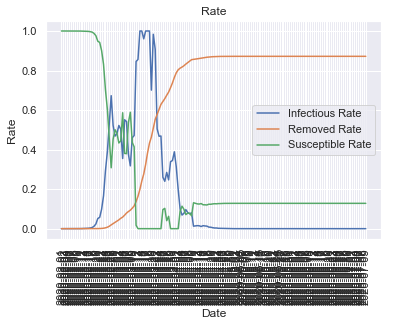

--------------------------------------------------------
first beta=2.604777131940444e-06, first gamma=0.0
last beta=3.452366504786628e-08, last gamma=0.50562


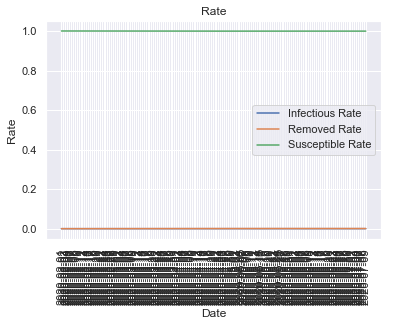

--------------------------------------------------------
first beta=3.069452432447968e-06, first gamma=0.0
last beta=1.336681124594109e-07, last gamma=0.50562


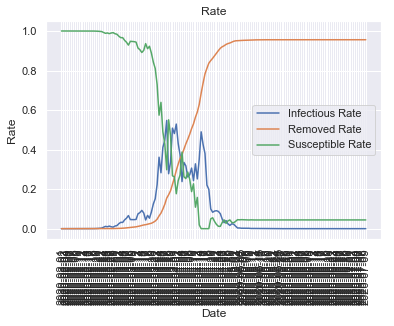

--------------------------------------------------------
first beta=3.4752759786051317e-06, first gamma=0.0
last beta=1.0053421136612244e-07, last gamma=0.50562


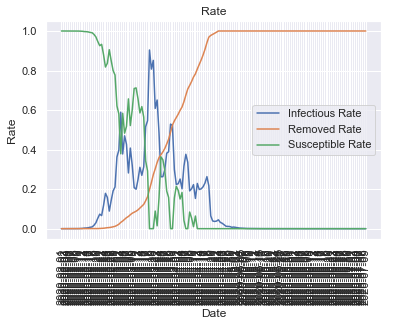

--------------------------------------------------------
first beta=2.9918735520788023e-06, first gamma=0.0
last beta=1.4636618985464883e-07, last gamma=0.50562


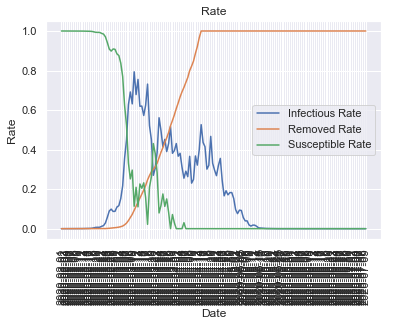

--------------------------------------------------------
first beta=3.115591493257436e-06, first gamma=0.0
last beta=1.60558349854902e-07, last gamma=0.50562


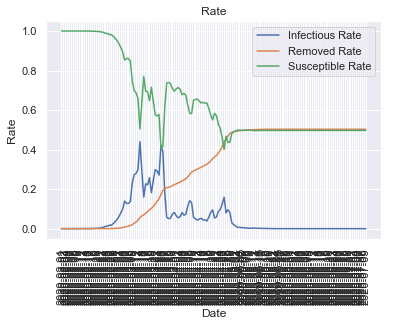

--------------------------------------------------------
first beta=2.400267366422011e-06, first gamma=0.0
last beta=8.375569851006266e-08, last gamma=0.50562


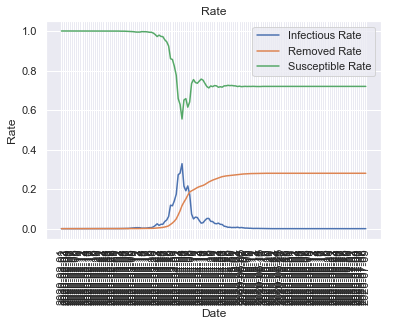

--------------------------------------------------------
first beta=2.6653005749411073e-06, first gamma=0.0
last beta=1.1701930993856071e-07, last gamma=0.50562


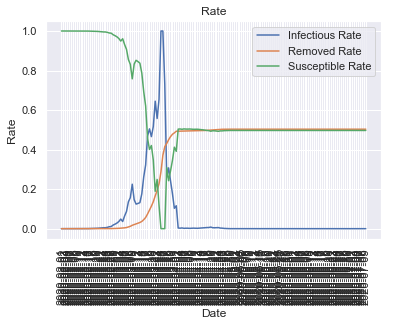

--------------------------------------------------------
first beta=3.4050711272089387e-06, first gamma=0.0
last beta=5.781260168399598e-08, last gamma=0.50562


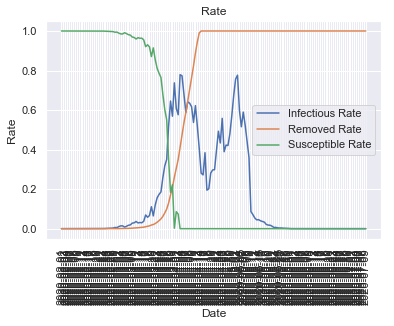

--------------------------------------------------------
first beta=2.441451100124066e-06, first gamma=0.0
last beta=2.5638874071220634e-07, last gamma=0.50562


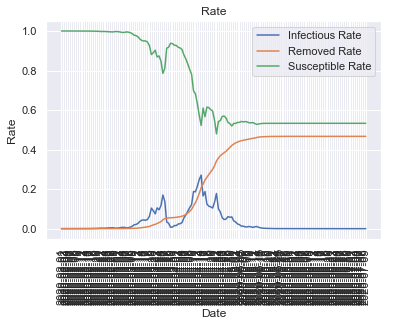

--------------------------------------------------------
first beta=2.744927615444807e-06, first gamma=0.0
last beta=1.485233465297832e-07, last gamma=0.50562


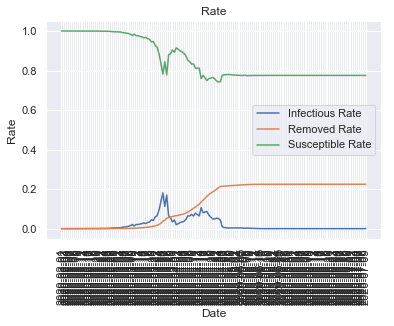

--------------------------------------------------------
first beta=2.6116589304757977e-06, first gamma=0.0
last beta=1.5122457108862634e-07, last gamma=0.50562


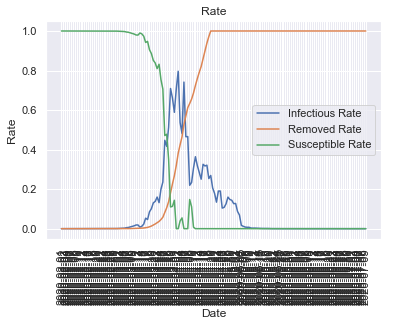

--------------------------------------------------------
first beta=2.4476728989428917e-06, first gamma=0.0
last beta=7.527573197700704e-08, last gamma=0.50562


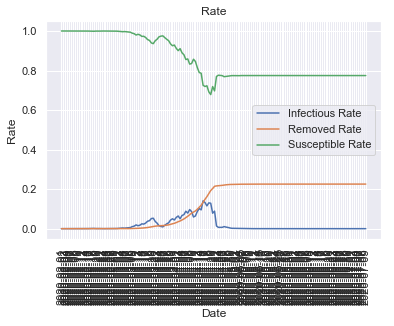

--------------------------------------------------------
first beta=2.609084265809646e-06, first gamma=0.0
last beta=2.5248770431347243e-07, last gamma=0.50562


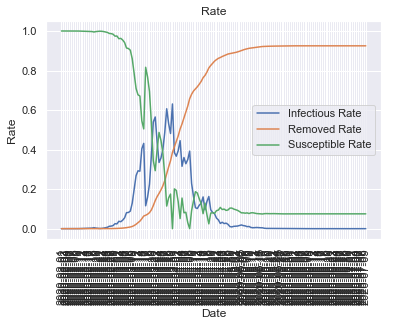

--------------------------------------------------------
first beta=3.2069377420825722e-06, first gamma=0.0
last beta=1.1577667715552298e-07, last gamma=0.50562


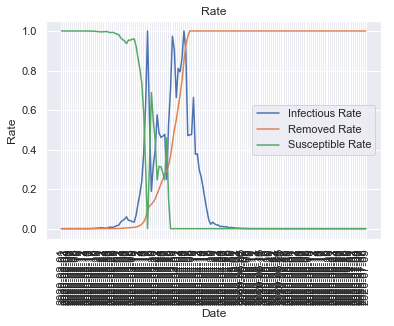

--------------------------------------------------------
first beta=2.785336476522902e-06, first gamma=0.0
last beta=3.899271395666528e-08, last gamma=0.50562


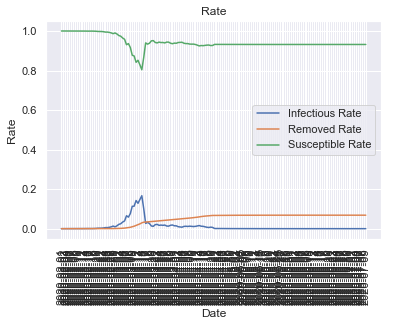

--------------------------------------------------------
first beta=2.4180464750567073e-06, first gamma=0.0
last beta=1.2023616530158868e-07, last gamma=0.50562


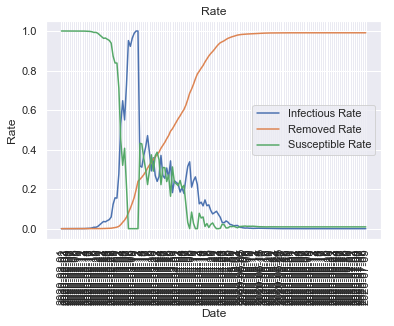

--------------------------------------------------------
first beta=3.0597313020388135e-06, first gamma=0.0
last beta=1.6580305546471015e-07, last gamma=0.50562


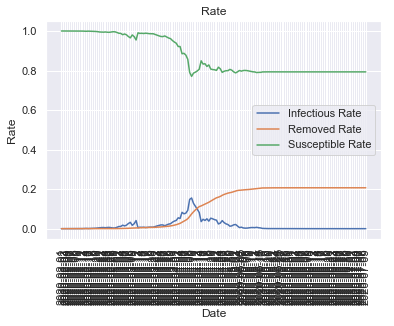

--------------------------------------------------------
first beta=3.0155301974501492e-06, first gamma=0.0
last beta=1.9481253386489908e-07, last gamma=0.50562


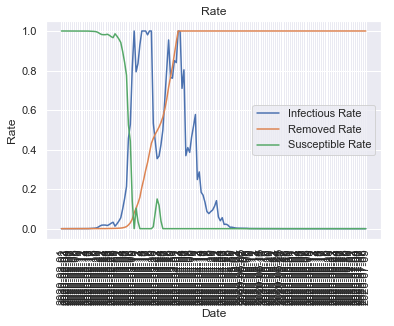

--------------------------------------------------------
first beta=2.6984247604918236e-06, first gamma=0.0
last beta=3.0737921124345054e-07, last gamma=0.50562


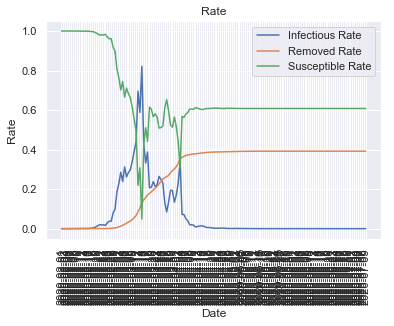

--------------------------------------------------------
first beta=2.9207573234459107e-06, first gamma=0.0
last beta=1.1478510308596782e-07, last gamma=0.50562


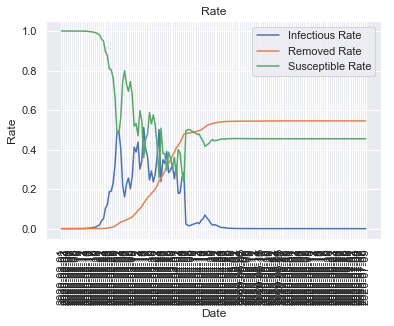

--------------------------------------------------------
first beta=2.463768231622932e-06, first gamma=0.0
last beta=1.4818146308353336e-07, last gamma=0.50562


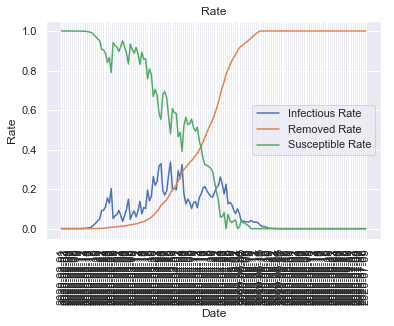

In [54]:
# Large Noise
for i in range(100):
    # Total population, N.
    N = 200000
    # Initial number of infected and recovered individuals, I0 and R0.
    I, R = 1, 0.0
    # Everyone else, S0, is susceptible to infection initially.
    S = N - I - R
    # A grid of time points (in days)
    days = 160
    t = np.linspace(0, days, days)

    # Initial conditions vector
    y = S, I, R

    # Static
    # beta = random.uniform(1e-7, 5e-6)
    # gamma = 0.1
    # # Integrate the SIR equations over the time grid, t.
    # ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    # S, I, R = ret.T
    # sir_df = pd.DataFrame({
    #     'Code': "SIR-{}".format(i),
    #     'confirmed': I,
    #     'removed': R,
    #     'susceptible': S,
    #     'infectious_rate': I/N,
    #     'removed_rate': R/N,
    #     'susceptible_rate': S/N
    # })

    # Dynamic
    beta = random.uniform(2.3e-6, 3.5e-6)
    # gamma = 0.1
    sir_df = pd.DataFrame(index=[], columns=cols)
    sus, inf, rec= [],[],[]
    print("--------------------------------------------------------")
    print("first beta={}, first gamma={}".format(beta, gamma(0)))
    for day in range(days):
        if day % 10 == 0:
            beta = beta * random.uniform(0.66, 1)
        sus.append(S)
        inf.append(I)
        rec.append(R)
#         S_ = S
#         I_ = I
#         R_ = R
#         I = I_ + beta * S_ * I_ - gamma(day) * I_ + I_*0.3*np.random.normal(loc=0, scale=1)
#         R = R_ + gamma(day) * I_
#         S = N - I - R
        S_ = S
        I_ = I *(1 - 0.3*np.random.normal(loc=0, scale=1))
        R_ = R
        I = max(I_ + beta * S_ * I_ - gamma(day) * I_, 0) 
        R = max(R_ + gamma(day) * I_, 0)
        S = max(N - I - R,0)
        I = min(I, N)
        R = min(R, N)
    sir_df["confirmed"] = inf
    sir_df["removed"] = rec
    sir_df["susceptible"] = sus
    sir_df["infectious_rate"] = (np.array(inf)/N).tolist()
    sir_df["removed_rate"] = (np.array(rec)/N).tolist()
    sir_df["susceptible_rate"] = (np.array(sus)/N).tolist()
    sir_df["Code"] = "SIR-large-{}".format(i)

    # Rate change
    sir_df["infectious_rate_change"] = sir_df["infectious_rate"].pct_change()
    sir_df["infectious_rate_change"] = sir_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    sir_df["removed_rate_change"] = sir_df["removed_rate"].pct_change()
    sir_df["removed_rate_change"] = sir_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    sir_df["susceptible_rate_change"] = sir_df["susceptible_rate"].pct_change()
    sir_df["susceptible_rate_change"] = sir_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Add Date
    sir_df["Date"] = dates

    print("last beta={}, last gamma={}".format(beta, gamma(days-1)))
    display_rate(sir_df)
    SIR_df = pd.concat([SIR_df, sir_df])

In [55]:
# train_df = new_df
train_df = SIR_df.copy()
train_df.tail()

Code        Date     confirmed   removed  susceptible  \
155  SIR-large-99  2020-07-05  2.151323e-09  200000.0          0.0   
156  SIR-large-99  2020-07-06  5.625512e-10  200000.0          0.0   
157  SIR-large-99  2020-07-07  2.178367e-10  200000.0          0.0   
158  SIR-large-99  2020-07-08  9.898386e-11  200000.0          0.0   
159  SIR-large-99  2020-07-09  6.374968e-11  200000.0          0.0   

     infectious_rate  removed_rate  susceptible_rate  infectious_rate_change  \
155     1.075662e-14           1.0               0.0               -0.682920   
156     2.812756e-15           1.0               0.0               -0.738509   
157     1.089184e-15           1.0               0.0               -0.612770   
158     4.949193e-16           1.0               0.0               -0.545605   
159     3.187484e-16           1.0               0.0               -0.355959   

     removed_rate_change  susceptible_rate_change  
155                  0.0                      0.0  
156                  0.0                      0.0  
157                  0.0                      0.0  
158                  0.0                      0.0  
159                  0.0                      0.0

In [56]:
# Creating train input from DataFrames
# train_country = ["KOR", "TWA", "THA", "ITA", "ISL", "DNK"]
# train_df = train_df.query("Code in {}".format(train_country))
days_in_sequence = 21
output_days = 7

trend_list = []

# for code in train_df.Code.unique():
for i in range(100):
    code = "SIR-small-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_rate] 

            #prepare outputs
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

sequence_length = days_in_sequence - 1
training_percentage = 0.9
temp_dim = 3

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

# 3. Model

In [57]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_dim))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
# demographic_input_layer = Input(shape=(dem_dim,))
# demographic_dense = layers.Dense(16)(demographic_input_layer)
# demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
# merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(16)(rnn_c)
dropout_c = layers.Dropout(0.3)(dense_c)
output_c = layers.Dense(7)(dropout_c) #activation=layers.LeakyReLU(alpha=0.1)
cases = layers.LeakyReLU(alpha=0.1,name="infectious")(output_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
# merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(16)(rnn_f)
dropout_f = layers.Dropout(0.3)(dense_f)
output_f = layers.Dense(7)(dropout_f)
fatalities = layers.LeakyReLU(alpha=0.1, name="removed")(output_f)


model = Model([temporal_input_layer], [cases,fatalities])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 3)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 20, 64)       17408       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 32)           12416       lstm_3[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 32)           12416       lstm_3[0][0]                     
__________________________________________________________________________________________________
dense_4 (D

In [58]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.6), #patience=4  #EarlyStopping(monitor='val_loss', patience=20)
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.mean_squared_logarithmic_error,tf.keras.losses.mean_squared_logarithmic_error], optimizer="adam")

In [59]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 50, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 3967 samples, validate on 441 samples
Epoch 1/50
3967/3967 [==============================] - 17s 4ms/step - loss: 0.0650 - infectious_loss: 0.0114 - removed_loss: 0.0536 - val_loss: 0.0221 - val_infectious_loss: 0.0087 - val_removed_loss: 0.0134
Epoch 2/50
3967/3967 [==============================] - 12s 3ms/step - loss: 0.0322 - infectious_loss: 0.0077 - removed_loss: 0.0245 - val_loss: 0.0206 - val_infectious_loss: 0.0068 - val_removed_loss: 0.0137
Epoch 3/50
3967/3967 [==============================] - 13s 3ms/step - loss: 0.0268 - infectious_loss: 0.0064 - removed_loss: 0.0205 - val_loss: 0.0210 - val_infectious_loss: 0.0062 - val_removed_loss: 0.0148
Epoch 4/50
3967/3967 [==============================] - 14s 4ms/step - loss: 0.0226 - infectious_loss: 0.0051 - removed_loss: 0.0174 - val_loss: 0.0183 - val_infectious_loss: 0.0053 - val_removed_loss: 0.0131
Epoch 5/50
3967/3967 [==============================] - 14s 4ms/step - loss: 0.0226 - infectious_loss: 0.0049 - remov

In [60]:
# Create large noise data
days_in_sequence = 21
output_days = 7

trend_list = []

# for code in train_df.Code.unique():
for i in range(100):
    code = "SIR-large-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_rate] 

            #prepare outputs
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)
print(len(trend_df))
trend_df.head()

sequence_length = days_in_sequence - 1
training_percentage = 0.9

temp_dim = 3

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

1400


In [61]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train],
          initial_epoch=50,
          epochs = 100, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 51/100
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0049 - infectious_loss: 0.0034 - removed_loss: 0.0015 - val_loss: 0.0062 - val_infectious_loss: 0.0053 - val_removed_loss: 8.6017e-04
Epoch 52/100
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0046 - infectious_loss: 0.0033 - removed_loss: 0.0013 - val_loss: 0.0062 - val_infectious_loss: 0.0055 - val_removed_loss: 7.5360e-04
Epoch 53/100
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0046 - infectious_loss: 0.0033 - removed_loss: 0.0013 - val_loss: 0.0058 - val_infectious_loss: 0.0051 - val_removed_loss: 6.7771e-04
Epoch 54/100
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0046 - infectious_loss: 0.0034 - removed_loss: 0.0012 - val_loss: 0.0059 - val_infectious_loss: 0.0052 - val_removed_loss: 6.4912e-04
Epoch 55/100
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0045 - infectious

# 4. Performance during training

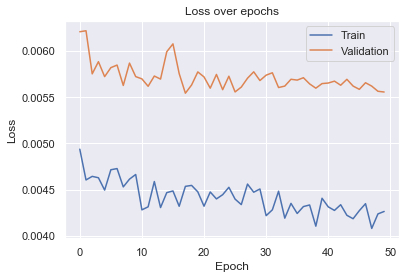

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

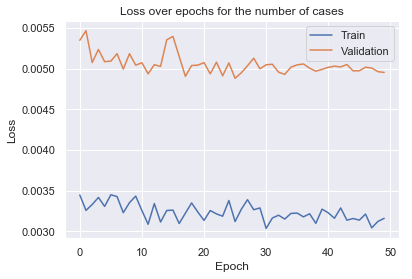

In [63]:
plt.plot(history.history['infectious_loss'])
plt.plot(history.history['val_infectious_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

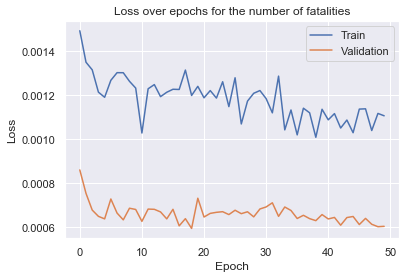

In [64]:
plt.plot(history.history['removed_loss'])
plt.plot(history.history['val_removed_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

In [65]:
model.load_weights("best_model.h5")
predictions = model.predict([X_temporal_test])

In [66]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected infectious rate:", exp_cases)
    print("Prediction:", pred_cases)
    print("Expected removed rate:", exp_fatalities)
    print("Prediction:", pred_fatalities)

[[1.6332828e-05 1.2757514e-01 8.7240851e-01]
 [1.5648113e-05 1.2757999e-01 8.7240434e-01]
 [1.4272009e-05 1.2758453e-01 8.7240118e-01]
 [1.2149563e-05 1.2758848e-01 8.7239939e-01]
 [8.5696329e-06 1.2759133e-01 8.7240010e-01]
 [6.2452518e-06 1.2759346e-01 8.7240028e-01]
 [4.9544537e-06 1.2759519e-01 8.7239987e-01]
 [4.3925897e-06 1.2759677e-01 8.7239885e-01]
 [1.7565212e-06 1.2759741e-01 8.7240082e-01]
 [1.5994063e-06 1.2759800e-01 8.7240040e-01]
 [1.1562163e-06 1.2759845e-01 8.7240040e-01]
 [7.8911370e-07 1.2759876e-01 8.7240046e-01]
 [5.3568442e-07 1.2759897e-01 8.7240046e-01]
 [4.5996353e-07 1.2759916e-01 8.7240040e-01]
 [2.9468762e-07 1.2759928e-01 8.7240040e-01]
 [2.4004655e-07 1.2759939e-01 8.7240034e-01]
 [6.0303968e-08 1.2759942e-01 8.7240052e-01]
 [5.5688417e-08 1.2759945e-01 8.7240052e-01]
 [5.0236324e-08 1.2759946e-01 8.7240046e-01]
 [5.3931792e-08 1.2759949e-01 8.7240046e-01]]
Expected infectious rate: [4.83592189e-08 1.42523255e-08 1.37345557e-08 8.26113666e-09
 9.09507758e

# 6. Apply the model to predict future trends

In [67]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date(code, date, gdf):
    start_date = date - timedelta(days=days_in_sequence-1)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = gdf[(gdf["Code"] == code) & (gdf["Date"] >= str_start_date) & (gdf["Date"] <= str_end_date)]

    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["infectious_rate"],
                                                 tdf["removed_rate"],
                                                 tdf["susceptible_rate"]]),
                                     (3,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [68]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(days_in_sequence)
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days+1, days_in_sequence)]
    for date in date_list:
        date_until = date + timedelta(days=output_days-1)
        input_data = build_inputs_for_date(code, date, gdf)
        result = model.predict(input_data)

        # add predicted results
        # pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate", "removed_rate"]] = [result[0][0][0], result[1][0][0]]
        pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["infectious_rate"]] = result[0][0].tolist()
        pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["removed_rate"]] = result[1][0].tolist()
        
    return pdf

In [69]:
#The functions that are called here need to optimise, sorry about that!
# test_country = ["DEU", "FRA"]
# test_country = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]
# pdf = new_df.copy().query("Code in {}".format(test_country)) # prediction data frame

pdf = SIR_df.copy()
pdf["infectious_rate"] = np.nan
pdf["removed_rate"] = np.nan

gdf = SIR_df.copy()

with tqdm(total=len(list(pdf.Code.unique()))) as pbar:
#     for code in test_country: #copy_df.Code.unique()
#         pdf = predict_for_region(code, pdf)
    for code in range(81, 100):
        pdf = predict_for_region("SIR-large-{}".format(code), pdf, gdf)
        pbar.update(1)
pdf.to_csv("./predictions.csv")

  0%|          | 0/200 [00:00<?, ?it/s]

prediction start date: 2020-02-22


  0%|          | 1/200 [00:00<01:16,  2.59it/s]

prediction start date: 2020-02-22


  1%|          | 2/200 [00:00<01:19,  2.48it/s]

prediction start date: 2020-02-22


  2%|▏         | 3/200 [00:01<01:16,  2.58it/s]

prediction start date: 2020-02-22


  2%|▏         | 4/200 [00:01<01:14,  2.65it/s]

prediction start date: 2020-02-22


  2%|▎         | 5/200 [00:01<01:12,  2.70it/s]

prediction start date: 2020-02-22


  3%|▎         | 6/200 [00:02<01:10,  2.75it/s]

prediction start date: 2020-02-22


  4%|▎         | 7/200 [00:02<01:15,  2.56it/s]

prediction start date: 2020-02-22


  4%|▍         | 8/200 [00:03<01:18,  2.44it/s]

prediction start date: 2020-02-22


  4%|▍         | 9/200 [00:03<01:16,  2.51it/s]

prediction start date: 2020-02-22


  5%|▌         | 10/200 [00:03<01:16,  2.50it/s]

prediction start date: 2020-02-22


  6%|▌         | 11/200 [00:04<01:12,  2.61it/s]

prediction start date: 2020-02-22


  6%|▌         | 12/200 [00:04<01:18,  2.39it/s]

prediction start date: 2020-02-22


  6%|▋         | 13/200 [00:05<01:23,  2.24it/s]

prediction start date: 2020-02-22


  7%|▋         | 14/200 [00:05<01:18,  2.37it/s]

prediction start date: 2020-02-22


  8%|▊         | 15/200 [00:06<01:17,  2.39it/s]

prediction start date: 2020-02-22


  8%|▊         | 16/200 [00:06<01:23,  2.21it/s]

prediction start date: 2020-02-22


  8%|▊         | 17/200 [00:06<01:19,  2.29it/s]

prediction start date: 2020-02-22


  9%|▉         | 18/200 [00:07<01:18,  2.31it/s]

prediction start date: 2020-02-22


 10%|▉         | 19/200 [00:07<01:13,  2.45it/s]


# 7. Outputs: Observing the curves

In [70]:
dates = gdf.Date.unique()
dates = sorted(dates)
last_date = dates[-1]
print(last_date)

2020-07-09


In [71]:
def display_comparison(code,groundtruth_df):
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    prediction = pdf[(pdf["Code"] == code) & (pdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.infectious_rate.values)
    plt.plot(prediction.infectious_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.removed_rate.values)
    plt.plot(prediction.removed_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

------------------------------SIR-large-81---------------------------------


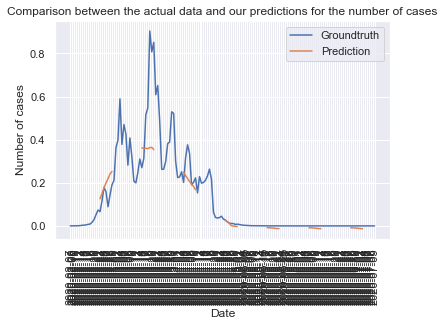

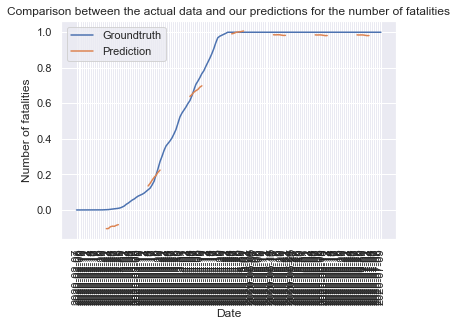

------------------------------SIR-large-82---------------------------------


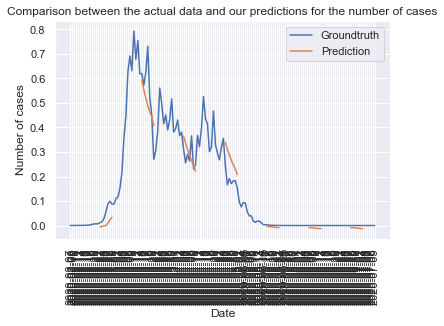

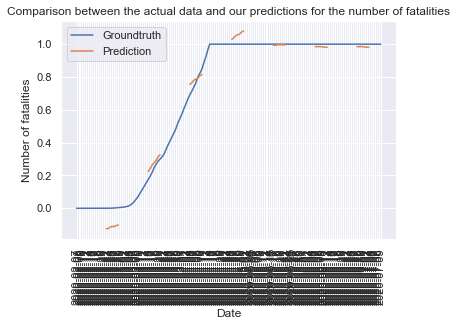

------------------------------SIR-large-83---------------------------------


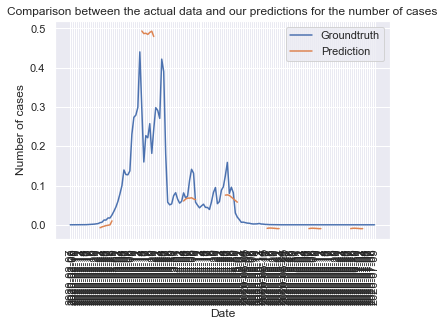

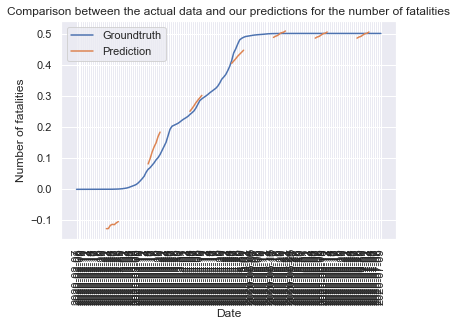

------------------------------SIR-large-84---------------------------------


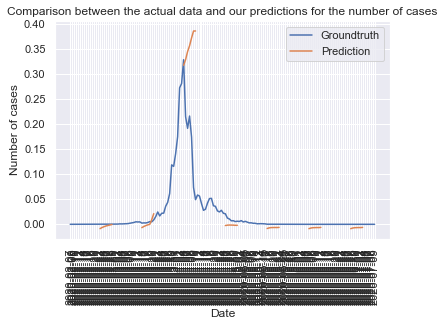

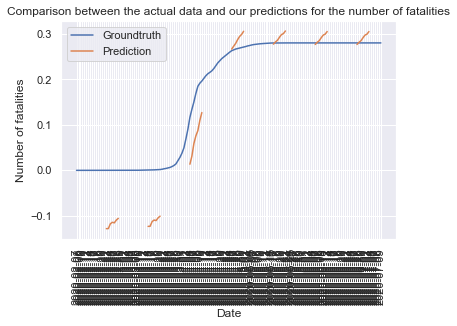

------------------------------SIR-large-85---------------------------------


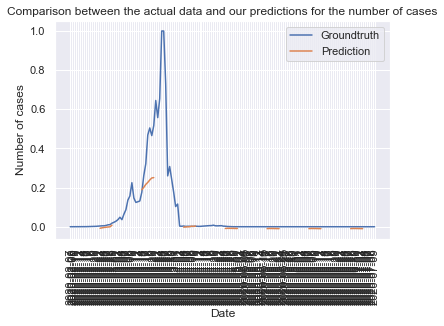

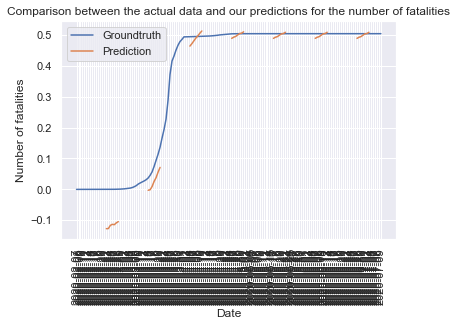

------------------------------SIR-large-86---------------------------------


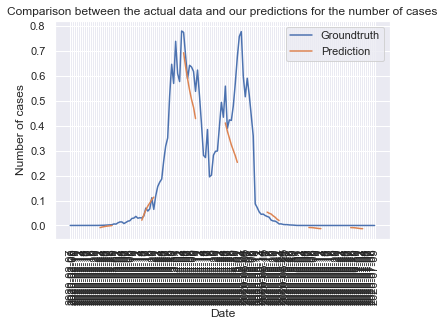

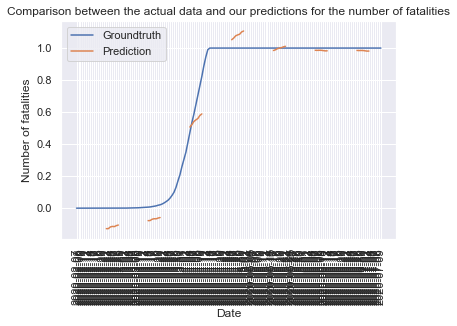

------------------------------SIR-large-87---------------------------------


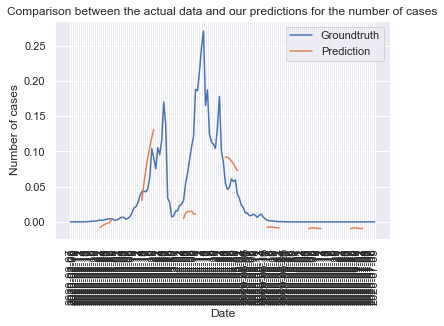

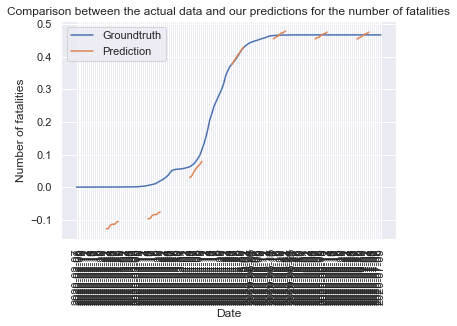

------------------------------SIR-large-88---------------------------------


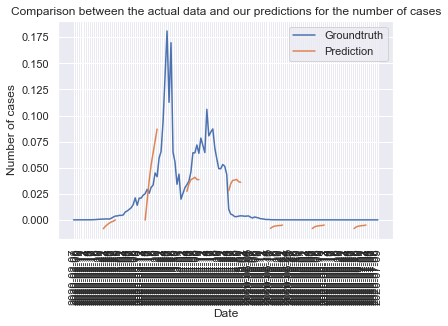

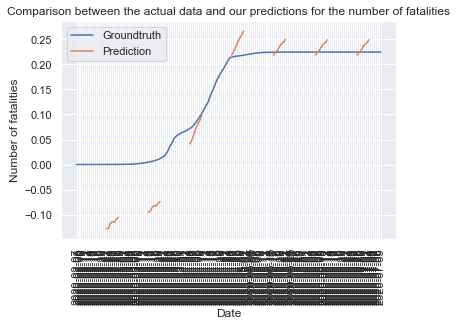

------------------------------SIR-large-89---------------------------------


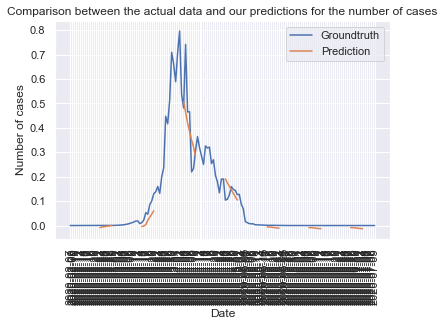

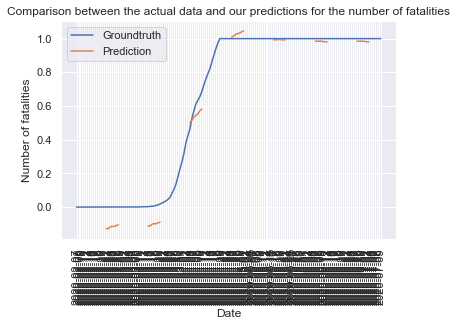

------------------------------SIR-large-90---------------------------------


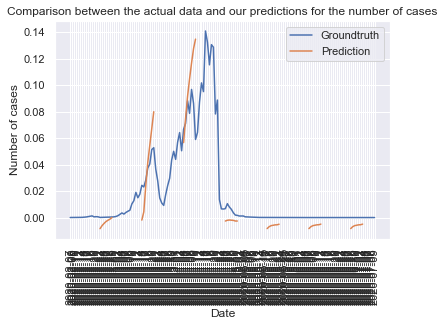

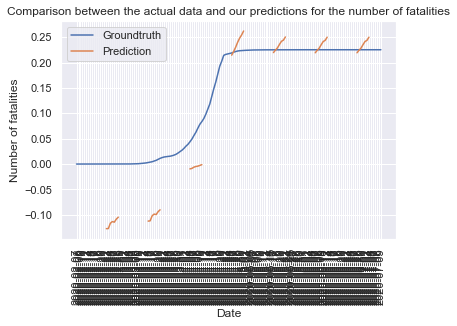

------------------------------SIR-large-91---------------------------------


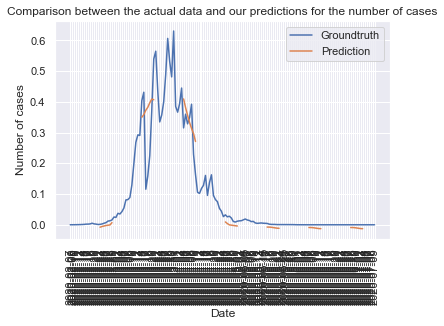

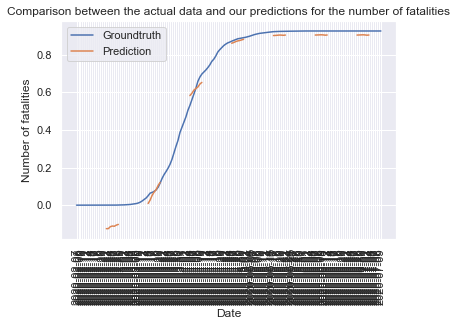

------------------------------SIR-large-92---------------------------------


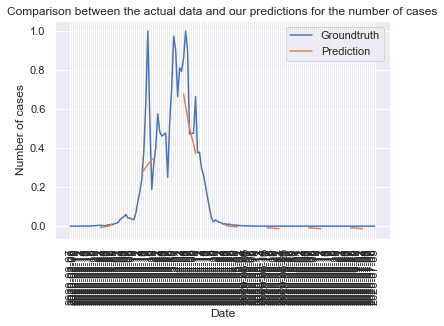

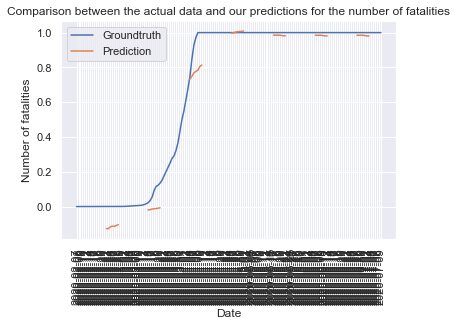

------------------------------SIR-large-93---------------------------------


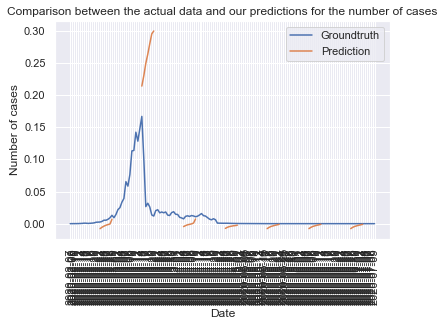

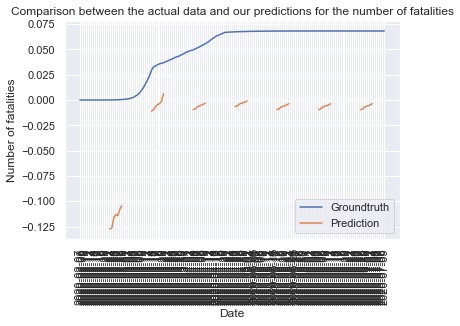

------------------------------SIR-large-94---------------------------------


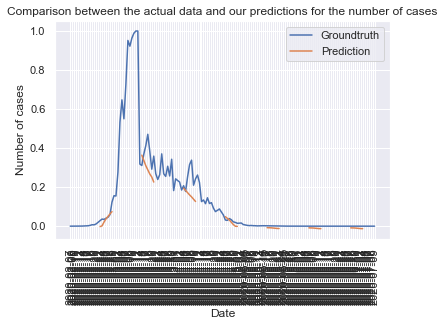

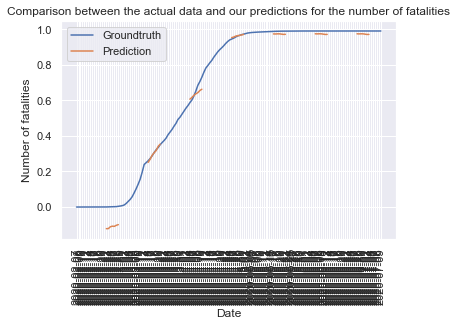

------------------------------SIR-large-95---------------------------------


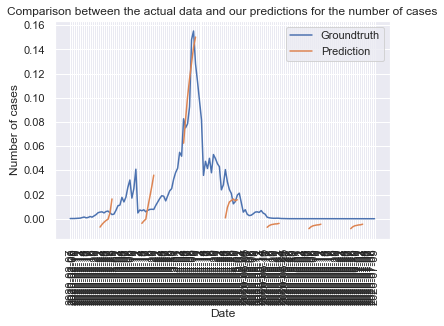

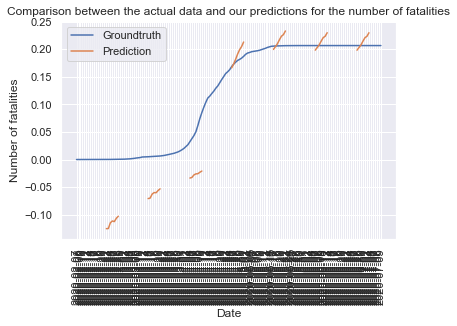

------------------------------SIR-large-96---------------------------------


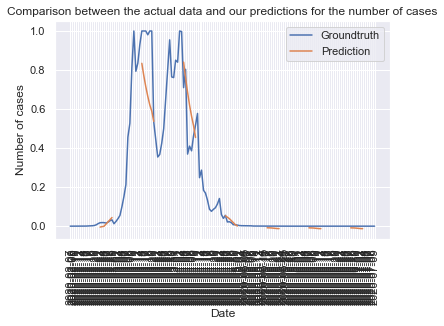

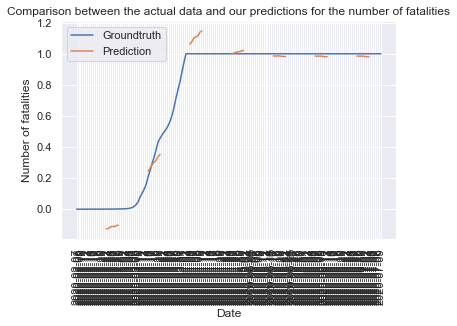

------------------------------SIR-large-97---------------------------------


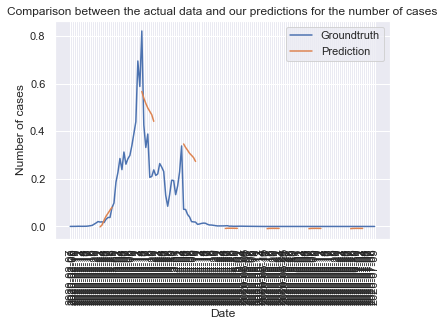

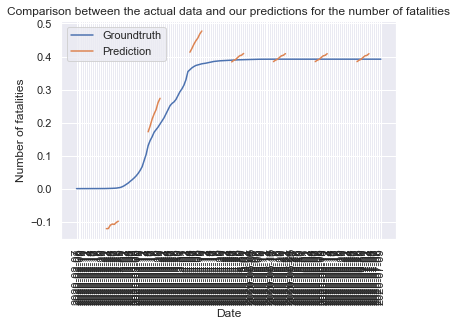

------------------------------SIR-large-98---------------------------------


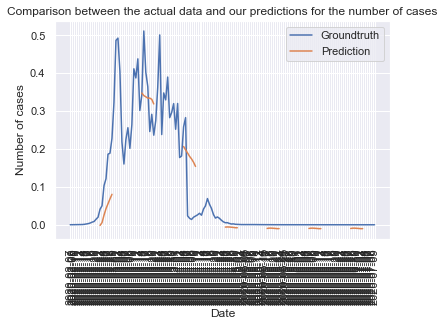

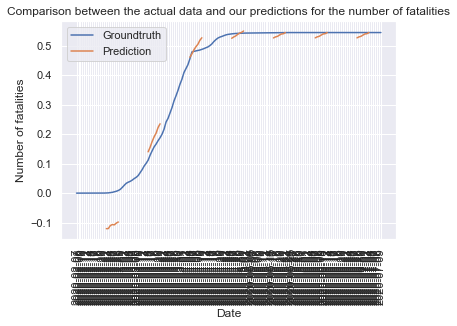

------------------------------SIR-large-99---------------------------------


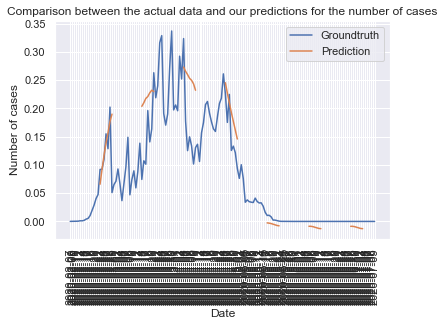

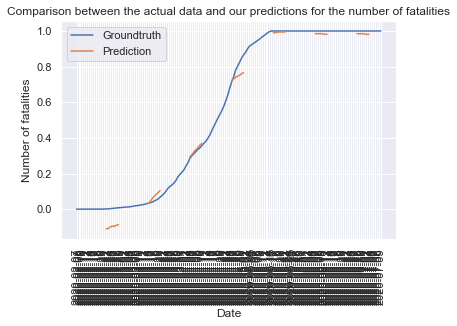

In [72]:
for code in range(81, 100):
    print("------------------------------SIR-large-{}---------------------------------".format(code))
    display_comparison("SIR-large-{}".format(code), gdf)